In [2]:
from ler.utils import interpolator_pickle_path, get_param_from_json, cubic_spline_interpolator, append_json, cubic_spline_interpolator2d_array, inverse_transform_sampler, pdf_cubic_spline_interpolator2d_array, inverse_transform_sampler2d, load_pickle, save_pickle
from ler.lens_galaxy_population import phi
import numpy as np
from scipy.integrate import quad, cumtrapz
from scipy.interpolate import interp1d, CubicSpline
from numba import njit
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

In [3]:
class FuntionConditioning():

    def __init__(self,
        function,  # can also be an array of function values 
        x_array,
        conditioned_y_array=None,  # if this is not none, 2D interpolation will be used
        param_dict_given={},
        directory='./interpolator_pickle',
        sub_directory='default',
        name='default',
        create_new=False,
        create_function=True,
        create_function_inverse=False,
        create_pdf=True,
        create_rvs=True,
        npool=4,
        multiprocessing=False,
    ):
        create = self.create_decision_function(create_function, create_function_inverse, create_pdf, create_rvs)
        
        if create:
            self.npool = npool
            self.multiprocessing = multiprocessing
            # create_interpolator input list
            input_list = [function, x_array, conditioned_y_array, create_function_inverse, create_pdf, create_rvs]

            # check first whether the directory, subdirectory and pickle exist
            path_inv_cdf, it_exist = interpolator_pickle_path(
                param_dict_given=param_dict_given,
                directory=directory,
                sub_directory=sub_directory,
                interpolator_name=name,
            )

            # if the interpolator exists, load it
            if create_new:
                it_exist = False

            if it_exist:
                print(f"{name} interpolator will be loaded from {path_inv_cdf}")
                # load the interpolator
                interpolator = load_pickle(path_inv_cdf)
            else:
                print(f"{name} interpolator will be generated at {path_inv_cdf}")
                interpolator = self.create_interpolator(*input_list)
                # save the interpolator
                save_pickle(path_inv_cdf, interpolator)

            x_array = interpolator['x_array']
            z_array = interpolator['z_array']
            y_array = interpolator['conditioned_y_array']
            function_spline = interpolator['function_spline']
            function_inverse_spline = interpolator['function_inverse_spline']
            pdf_norm_const = interpolator['pdf_norm_const']
            cdf_values = interpolator['cdf_values']

            if y_array is None:
                # function is 1D
                self.function = njit(lambda x: cubic_spline_interpolator(x, function_spline, x_array)) if create_function else None
                # inverse function is 1D
                self.function_inverse = njit(lambda x: cubic_spline_interpolator(x, function_inverse_spline, z_array)) if create_function_inverse else None

                # pdf is 1D
                self.pdf = njit(lambda x: cubic_spline_interpolator(x, function_spline, x_array)/pdf_norm_const) if create_pdf else None
                # sampler is 1D
                self.rvs = njit(lambda size: inverse_transform_sampler(size, cdf_values, x_array)) if create_rvs else None
                
            else:
                # print out type of  function_spline, x_array, y_array
                # print(type(function_spline), type(x_array), type(y_array))
                self.function = njit(lambda x, y: cubic_spline_interpolator2d_array(x, y, function_spline, x_array, y_array)) if create_function else None

                self.function_inverse = njit(lambda x, y: cubic_spline_interpolator2d_array(x, y, function_inverse_spline, z_array, y_array)) if create_function_inverse else None

                self.pdf = njit(lambda x, y: pdf_cubic_spline_interpolator2d_array(x, y, pdf_norm_const, function_spline, x_array, y_array)) if create_pdf else None

                self.rvs = njit(lambda size, y: inverse_transform_sampler2d(size, y, cdf_values, x_array, y_array)) if create_rvs else None

            self.x_array = x_array
            self.z_array = z_array
            self.conditioned_y_array = y_array
            self.function_spline = function_spline
            self.function_inverse_spline = function_inverse_spline
            self.pdf_norm_const = pdf_norm_const
            self.cdf_values = cdf_values

    def create_decision_function(self, create_function, create_function_inverse, create_pdf, create_rvs):

        if not isinstance(create_function, bool) and callable(create_function):
            self.function = create_function
            return False
        if not isinstance(create_function_inverse, bool) and callable(create_function_inverse):
            self.function_inverse = create_function_inverse
            return False
        if not isinstance(create_pdf, bool) and callable(create_pdf):
            self.pdf = create_pdf
            return False
        if not isinstance(create_rvs, bool) and callable(create_rvs):
            self.rvs = create_rvs
            return False
        
        return True


    def create_interpolator(self, function, x_array, conditioned_y_array, create_function_inverse, create_pdf, create_rvs):

        # function can be numpy array or callable
        # x_array, z_array are 2D arrays if conditioned_y_array is not None
        x_array, z_array, conditioned_y_array = self.create_z_array(x_array, function, conditioned_y_array, create_pdf, create_rvs)
        del function

        function_spline = self.function_spline_generator(x_array, z_array, conditioned_y_array)

        if create_function_inverse:
            # check z_array is strictly increasing
            if not np.all(np.diff(z_array) > 0):
                raise ValueError("z_array must be strictly increasing")
            function_inverse_spline = self.function_spline_generator(z_array, x_array, conditioned_y_array)
        else:
            function_inverse_spline = None

        if create_pdf or create_rvs:
            # cannot have -ve pdf
            pdf_norm_const = self.pdf_norm_const_generator(x_array, z_array, function_spline, conditioned_y_array)

            if create_rvs:
                cdf_values = self.cdf_values_generator(x_array, z_array, pdf_norm_const, conditioned_y_array)
            else:
                cdf_values = None
        else:
            pdf_norm_const = None
            cdf_values = None
            
        return {
            'x_array': x_array,
            'z_array': z_array,
            'conditioned_y_array': conditioned_y_array,
            'function_spline': function_spline,
            'function_inverse_spline': function_inverse_spline,
            'pdf_norm_const': pdf_norm_const,
            'cdf_values': cdf_values,
        }

    def create_z_array(self, x_array, function, conditioned_y_array, create_pdf, create_rvs):

        if callable(function):
            # 1D
            if conditioned_y_array is None:
                z_array = function(x_array)
                # remove nan values
                idx = np.argwhere(np.isnan(z_array))
                x_array = np.delete(x_array, idx)
                z_array = np.delete(z_array, idx)
            # 2D
            else:
                # check if x_array is 2D, if not, make it 2D of shape (len(conditioned_y_array), len(x_array))
                if x_array.ndim == 1:
                    x_array = np.array([x_array]*len(conditioned_y_array))

                idx = np.argsort(conditioned_y_array)
                conditioned_y_array = conditioned_y_array[idx]
                # x_array is 2D here, each row corresponds to a different y value
                x_array = x_array[idx]
                # sort each row of x_array
                x_array = np.sort(x_array, axis=1)

                if self.multiprocessing:
                    z_array = function(x_array, conditioned_y_array)
                else:
                    z_list = []
                    for i, y in enumerate(conditioned_y_array):
                        try:
                            z_list.append(function(x_array[i], y*np.ones_like(x_array[i])))
                        except:
                            z_list.append(function(x_array[i], y))
                    z_array = np.array(z_list)
        else:
            if conditioned_y_array is None:
                z_array = function
                # remove nan values
                idx = np.argwhere(np.isnan(z_array))
                x_array = np.delete(x_array, idx)
                z_array = np.delete(z_array, idx)
            else:
                if x_array.ndim == 1:
                    x_array = np.array([x_array]*len(conditioned_y_array))
                if function.ndim == 1:
                    raise ValueError('function must be 2D array if conditioned_y_array is not None')
                # row sort
                idx = np.argsort(conditioned_y_array)
                conditioned_y_array = conditioned_y_array[idx]
                # x_array is 2D here, each row corresponds to a different y value
                x_array = x_array[idx]
                z_array = function[idx]

                z_list = []
                x_list = []
                for i in range(len(conditioned_y_array)):
                    # column sort
                    idx = np.argsort(x_array[i])
                    x_ = x_array[i][idx]
                    z_ = z_array[i][idx]

                x_array = np.array(x_list)
                z_array = np.array(z_list)

        # cannot have -ve pdf
        if create_pdf or create_rvs:
            z_array[z_array < 0.0] = 0.0

        return x_array, z_array, conditioned_y_array

    def cdf_values_generator(self, x_array, z_array, pdf_norm_const, conditioned_y_array):
        # 1D case
        if conditioned_y_array is None:
            # z_array[z_array<0.] = 0. # already done
            cdf_values = cumtrapz(z_array/pdf_norm_const, x_array, initial=0)
        # 2D case
        else:
            cdf_values = []
            for i, y in enumerate(conditioned_y_array):
                z_array_ = z_array[i]
                z_array_[z_array_<0.] = 0.
                pdf_norm_ = pdf_norm_const[i]
                cdf_values.append(cumtrapz(z_array_/pdf_norm_, x_array[i], initial=0))

        return np.array(cdf_values)
    
    def pdf_norm_const_generator(self, x_array, z_array, function_spline, conditioned_y_array):
        # 1D case
        if conditioned_y_array is None:
            pdf_unorm = lambda x: cubic_spline_interpolator(np.array([x]), function_spline, x_array)

            norm = quad(pdf_unorm, min(x_array), max(x_array))[0]
            return norm
        # 2D case
        else:
            norm = []
            for i, y in enumerate(conditioned_y_array):
                pdf_unorm = lambda x: cubic_spline_interpolator(np.array([x]), function_spline[i], x_array[i])

                norm.append(quad(pdf_unorm, min(x_array[i]), max(x_array[i]))[0])

            return np.array(norm)
    
    def function_spline_generator(self, x_array, z_array, conditioned_y_array):
        # 1D case
        if conditioned_y_array is None:
            function_spline = CubicSpline(x_array, z_array).c
        # 2D case
        else:
            function_spline = []
            print(f"z_array shape: {z_array.shape}")
            print(f"x_array shape: {x_array.shape}")
            for i, y in enumerate(conditioned_y_array):
                
                function_spline.append(CubicSpline(x_array[i], z_array[i]).c)
            
        return np.array(function_spline)

In [6]:
x_array = np.load('x_array.npy')
y_array = np.load('y_array.npy')
z_array = np.load('z_array.npy')

# from astropy.cosmology import LambdaCDM
# cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
# Dc = lambda z_: cosmo.comoving_distance(z_).value
# x_array = np.geomspace(0.001, 10.0, 1000)
# z_array = Dc(x_array)

In [5]:
from ler.utils import FuntionConditioning
import numpy as np
from numba import njit

phi_min = 0.
phi_max = 2*np.pi
phi_rvs = njit(lambda size: np.random.uniform(
    low=phi_min,
    high=phi_max,
    size=size,
))

phi_object =FuntionConditioning(
    function=None,
    x_array=None,
    create_rvs=phi_rvs,
)

create: False


In [3]:
from ler.lens_galaxy_population import OpticalDepth, LensGalaxyParameterDistribution
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

od = OpticalDepth(
    npool=8,
    # create_new_interpolator=False,
    lens_param_samplers = dict(
        velocity_dispersion="velocity_dispersion_ewoud",
    ),
    create_new_interpolator=dict(
        cross_section=dict(create_new=False, resolution=1000000),
        lens_redshift=dict(create_new=False, resolution=50),
        optical_depth=dict(create_new=False, resolution=48),
    ),
)

# ler = LensGalaxyParameterDistribution(npool=8, lens_functions =  {
#         'strong_lensing_condition': 'rjs_with_cross_section_mp',
#         'cross_section': "cross_section_caustic_area",
#         },
#         buffer_size=int(2e5),
#         create_new_interpolator = dict(lens_parameters_kde_sl=dict(create_new=True, resolution=5000)),
# )
# 9m 31s, od:80,zl:20


Initializing OpticalDepth class

comoving_distance interpolator will be loaded from ./interpolator_pickle/comoving_distance/comoving_distance_1.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_1.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle

interpolated_cross_section_function

Interpolated cross section function loaded from ./interpolator_pickle/cross_section_function/cross_section_function_1.pickle
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion/velocity_dispersion_ewoud_3.pickle
using ler available axis_ratio function : axis_ratio_rayleigh
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_pickle/axis_ratio/axis_ratio_rayleigh_1.pickle
us

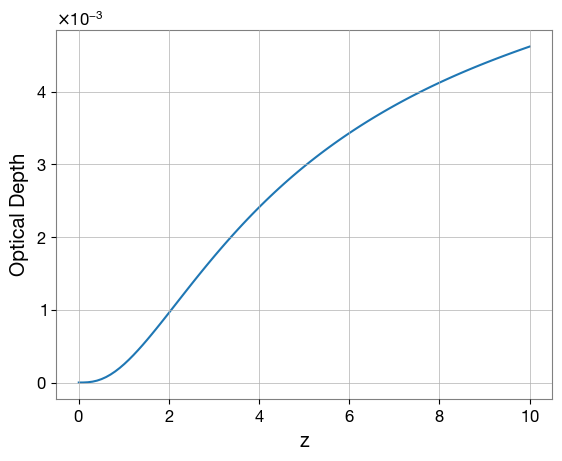

In [4]:
zs=np.linspace(0.001, 10.0, 100)
tau = od.optical_depth(zs)

# plot
plt.plot(zs, tau)
plt.xlabel('z')
plt.ylabel('Optical Depth')
plt.show()


In [ ]:
from ler.utils import FuntionConditioning
import numpy as np
from numba import njit

phi_rvs = njit(lambda size: np.random.uniform(
    low=phi_min,
    high=phi_max,
    size=size,
))
phi_pdf = lambda phi: 1/(phi_max-phi_min)

phi_object =FuntionConditioning(
    function=None,
    x_array=None,
    create_rvs=phi_rvs,
    create_pdf=phi_pdf,
    callback='rvs',
)
phi_object.rvs

In [14]:
sigma_range = np.linspace(10, 420, 200)
zl_range = np.linspace(0.001, 10, 200)
from ler.lens_galaxy_population import phi
# integrate phi(sigma, zl) over sigma and zl in the range. Use scipy
from scipy.integrate import dblquad

def phi_integrand(sigma, zl):
    return phi(np.array([sigma]), np.array([zl]))[0]

phi_integrated = dblquad(phi_integrand, zl_range[0], zl_range[1], lambda x: sigma_range[0], lambda x: sigma_range[1])

In [15]:
def normalized_phi(sigma, zl):
    return phi(sigma, zl) / phi_integrated

(2.5763605288418312e-05, 6.428721769685562e-12)

In [ ]:
def sample_sigma_zl(pdf, sigma_min, sigma_max, zl_min, zl_max, zs, chunk_size=100):

    x_sample = []
    y_sample = []
    for z in zs:

        xmin, xmax = sigma_min, sigma_max
        ymin, ymax = zl_min, z
        x = np.random.uniform(xmin, xmax, chunk_size)
        y = np.random.uniform(ymin, ymax, chunk_size)
        z = pdf(x, y)
        # Maximum value of the pdf
        zmax = np.max(z)

        # Rejection sample in chunks
        while True:
            x_try = np.random.uniform(xmin, xmax, size=chunk_size)
            y_try = np.random.uniform(ymin, ymax, size=chunk_size)
            pdf_xy_try = pdf(x_try, y_try)
            # this is for comparing with the pdf value at x_try, will be used to accept or reject the sample
            z_try = np.random.uniform(0, zmax, size=chunk_size)
            
            # Update the maximum value of the pdf
            zmax = max(zmax, np.max(pdf_xy_try))

            if np.sum(z_try < pdf_xy_try) > 0:
                x_sample.append(x_try[z_try < pdf_xy_try][0])
                y_sample.append(y_try[z_try < pdf_xy_try][0])
                break

        # Return the correct number of samples
        return np.array(x_sample), np.array(y_sample)

In [22]:
from numba import njit

@njit
def sample_sigma_zl(pdf, sigma_min, sigma_max, zl_min, zl_max, zs, chunk_size=1000):
    x_sample = []
    y_sample = []
    
    for z in zs:
        xmin, xmax = sigma_min, sigma_max
        ymin, ymax = zl_min, z
        
        # Keep sampling until a valid (sigma, zl) pair is found for this z
        while True:
            x_try = np.random.uniform(xmin, xmax, chunk_size)
            y_try = np.random.uniform(ymin, ymax, chunk_size)
            pdf_xy_try = pdf(x_try, y_try)
            zmax = np.max(pdf_xy_try)  # Maximum of the PDF for the current batch

            # Generate acceptance thresholds
            z_try = np.random.uniform(0, zmax, chunk_size)

            # Check which samples are accepted
            accepted_indices = z_try < pdf_xy_try
            if np.any(accepted_indices):
                # Accept the first valid sample
                x_sample.append(x_try[accepted_indices][0])
                y_sample.append(y_try[accepted_indices][0])
                break  # Exit the loop once the first valid sample is collected

    return np.array(x_sample), np.array(y_sample)

In [19]:
size = 5000
zs = ler.sample_source_redshift_sl(size)

In [23]:
sigma, zl = sample_sigma_zl(pdf=phi, sigma_min=10., sigma_max=420., zl_min=0.001, zl_max=10.0, zs=zs, chunk_size=1000)

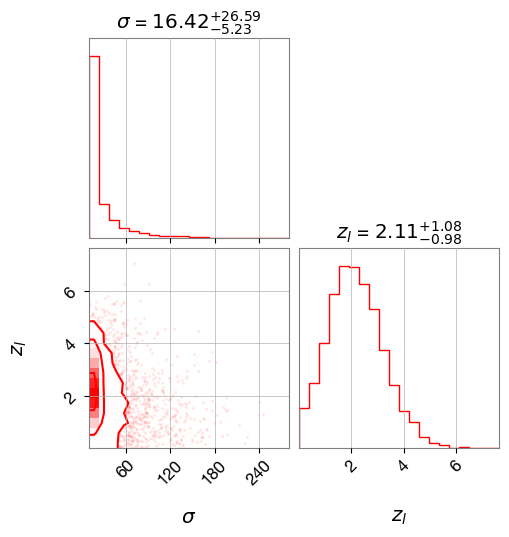

In [26]:
from corner import corner
import matplotlib.pyplot as plt

corner(np.vstack([sigma, zl]).T, labels=[r'$\sigma$', r'$z_l$'], show_titles=True, color='red')
plt.show()


In [34]:
ler.buffer_size = 200000
lens_param = ler.sample_lens_parameters(20000)

sampling lens parameters with sample_all_routine_epl_shear_sl...
current sampled size: 230
current sampled size: 469
current sampled size: 762
current sampled size: 1089
current sampled size: 1221
current sampled size: 1478
current sampled size: 1634
current sampled size: 1909
current sampled size: 2108
current sampled size: 2227
current sampled size: 2479
current sampled size: 2778
current sampled size: 3163
current sampled size: 3374
current sampled size: 3705
current sampled size: 4026
current sampled size: 4316
current sampled size: 4628
current sampled size: 4829
current sampled size: 5032
current sampled size: 5348
current sampled size: 5606
current sampled size: 5857
current sampled size: 6164
current sampled size: 6368
current sampled size: 6652
current sampled size: 6988
current sampled size: 7280
current sampled size: 7529
current sampled size: 7755
current sampled size: 8056
current sampled size: 8347
current sampled size: 8709
current sampled size: 8935
current sampled size

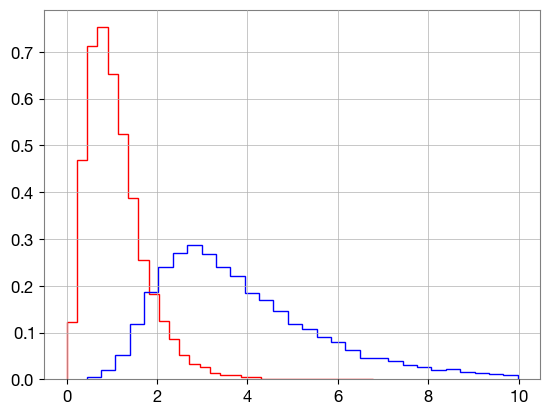

In [21]:
zl = lens_param['zl']
zs = lens_param['zs']
import matplotlib.pyplot as plt
plt.hist(zl, bins=50, histtype='step', color='red', density=True)
plt.hist(zs, bins=50, histtype='step', color='blue', density=True)
plt.show()



In [75]:
from ler.utils import append_json, get_param_from_json  

# lens_param=append_json('lens_param_cs_rjs_epl.json', lens_param, replace=False)
lens_param = get_param_from_json('lens_param_cs_rjs_epl.json')

In [18]:
np.mean(lens_param['gamma']), 2*np.mean(lens_param['gamma'])-1.5

(2.101332343896544, 2.7026646877930878)

In [84]:
# create scipy 2D kde
# from scipy.stats import kde

gamma1 = lens_param['gamma1']
gamma2 = lens_param['gamma2']
gamma = lens_param['gamma']
# kde1 = kde.gaussian_kde(gamma1, gamma2)
# kde2 = kde.gaussian_kde([gamma1, gamma2])

In [44]:
# save as txt lens_param['gamma']
np.savetxt('/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/lens_galaxy_population/lens_param_data/density_profile_slope_sl.txt', lens_param['gamma'])

In [45]:
np.savetxt('/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/lens_galaxy_population/lens_param_data/external_shear_sl.txt', np.array([lens_param['gamma1'], lens_param['gamma2']]) )

In [59]:
# load from txt
gamma = np.loadtxt('/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/lens_galaxy_population/lens_param_data/density_profile_slope_sl.txt')
gamma1, gamma2 = np.loadtxt('/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/lens_galaxy_population/lens_param_data/external_shear_sl.txt')

In [80]:
gamma

array([-0.00892265,  0.05631849, -0.0093382 , ..., -0.0098387 ,
        0.04189644,  0.03006984])

Note: you may need to restart the kernel to use updated packages.


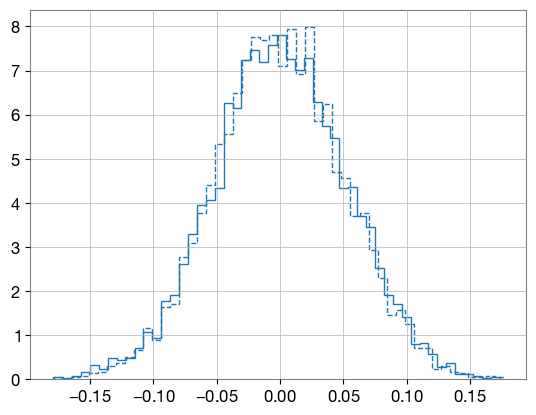

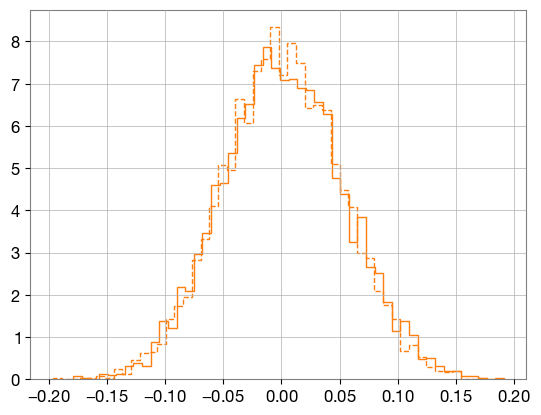

In [10]:
%pip install matplotlib

import matplotlib.pyplot as plt

#plt.hist(ler.density_profile_slope_sl(10000)[0], bins=50, histtype='step', density=True)
gamma1_, gamma2_ = ler.external_shear_sl(5000)
gamma1 = ler.external_shear_sl.x_array
gamma2 = ler.external_shear_sl.y_array
plt.hist(gamma1_, bins=50, histtype='step', density=True, color='C0')
plt.hist(gamma1, bins=50, histtype='step', density=True, color='C0', linestyle='--')
plt.show()

plt.hist(gamma2_, bins=50, histtype='step', density=True, color='C1')
plt.hist(gamma2, bins=50, histtype='step', density=True, color='C1', linestyle='--')
plt.show()

In [6]:
ler.density_profile_slope_sl.rvs(10000)

array([[1.86162581, 1.85086865, 1.91340285, ..., 2.09264322,
        2.08209867, 2.11448716]])

In [8]:
type(ler.density_profile_slope_sl.y_array)

NoneType

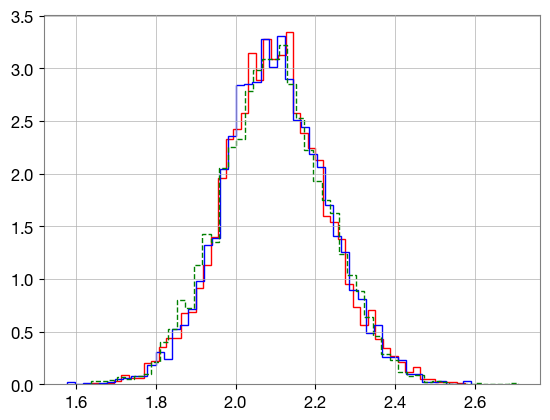

In [11]:
# from scipy.stats import gaussian_kde

# pdf values 
gamma_ = ler.density_profile_slope_sl.rvs(5000)
gamma = ler.density_profile_slope_sl.x_array

# plot
import matplotlib.pyplot as plt
plt.hist(gamma_, bins=50, histtype='step', density=True, color='red')
plt.hist(gamma, bins=50, histtype='step', density=True, color='blue')
data_sample = np.random.normal(2.091, 0.133, 5000)
plt.hist(data_sample, bins=50, histtype='step', color='green', density=True, linestyle='--')    
plt.show()

In [91]:
from scipy.stats import gaussian_kde
data = np.vstack([gamma1, gamma2])
kde_gamma12 = gaussian_kde(data)

kde_gamma12.resample(20000).shape

(2, 20000)

In [6]:
from ler.utils import FunctionConditioning
import numpy as np

gamma1, gamma2 = np.loadtxt('/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/lens_galaxy_population/lens_param_data/external_shear_sl.txt')

gamma12_object = FunctionConditioning(
    x_array=gamma1,
    y_array=gamma2,
    gaussian_kde=True,
    create_rvs=True,
    create_pdf=True,
    callback='rvs',
    create_new=False,
)


default interpolator will be loaded from ./interpolator_pickle/default/default_2.pickle


In [7]:
gamma1_, gamma2_ = gamma12_object.rvs(20000)

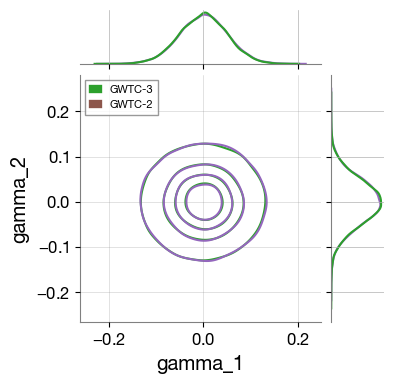

In [8]:
# use sns.jointplot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df1 = pd.DataFrame({'gamma_1': gamma1, 'gamma_2': gamma2, 'Type': 'data1'})
df2 = pd.DataFrame({'gamma_1': gamma1_, 'gamma_2': gamma2_, 'Type': 'data2'})
# Concatenate the dataframes
df_combined = pd.concat([df1, df2])

# plot
g = sns.jointplot(data=df_combined, x='gamma_1', y='gamma_2', hue='Type', kind='kde', alpha=1, height=4, ratio=4, palette={'data1': 'C2', 'data2': 'C4'}, levels=5, bw_adjust=1.8)

# change plot legend label fontsize
plt.setp(g.ax_joint.get_legend().get_texts(), fontsize='8')  # for legend text
plt.setp(g.ax_joint.get_legend().get_title(), fontsize='8')  # for legend title

# legend line
legend_lines = [Line2D([0], [0], color='C2', lw=1.5, alpha=1), Line2D([0], [0], color='C5', lw=1.5, alpha=1)]
g.ax_joint.legend(legend_lines, ['GWTC-3', 'GWTC-2'], loc='upper left', fontsize='8')

# Enhance style and visibility
g.ax_joint.grid(True, linestyle='-', linewidth='0.4', color='gray', alpha=0.4) 

# Set LaTeX labels
# g.set_axis_labels(r'$\text{m}^{src}_1 \;[M_\odot]$', r'$\text{m}^{src}_1 \;[\text{M}_\odot]$')
# plt.ylim(0, 50)
# plt.xlim(0, 50)

plt.show()

In [22]:
dict_ = dict(
    gamma=gamma,
    pdf=pdf
)
append_json('gamma_pdf.json', dict_, replace=False);

In [37]:
# nsl : no strong lensing
zs = lens_param['zs']
zl = lens_param['zl']
lens_param_nsl = ler.sampling_routine_epl_shear_nsl(zl,zs,20000)
lens_param_nsl['zl'] = zl
lens_param_nsl['zs'] = ler.sample_zs(20000)

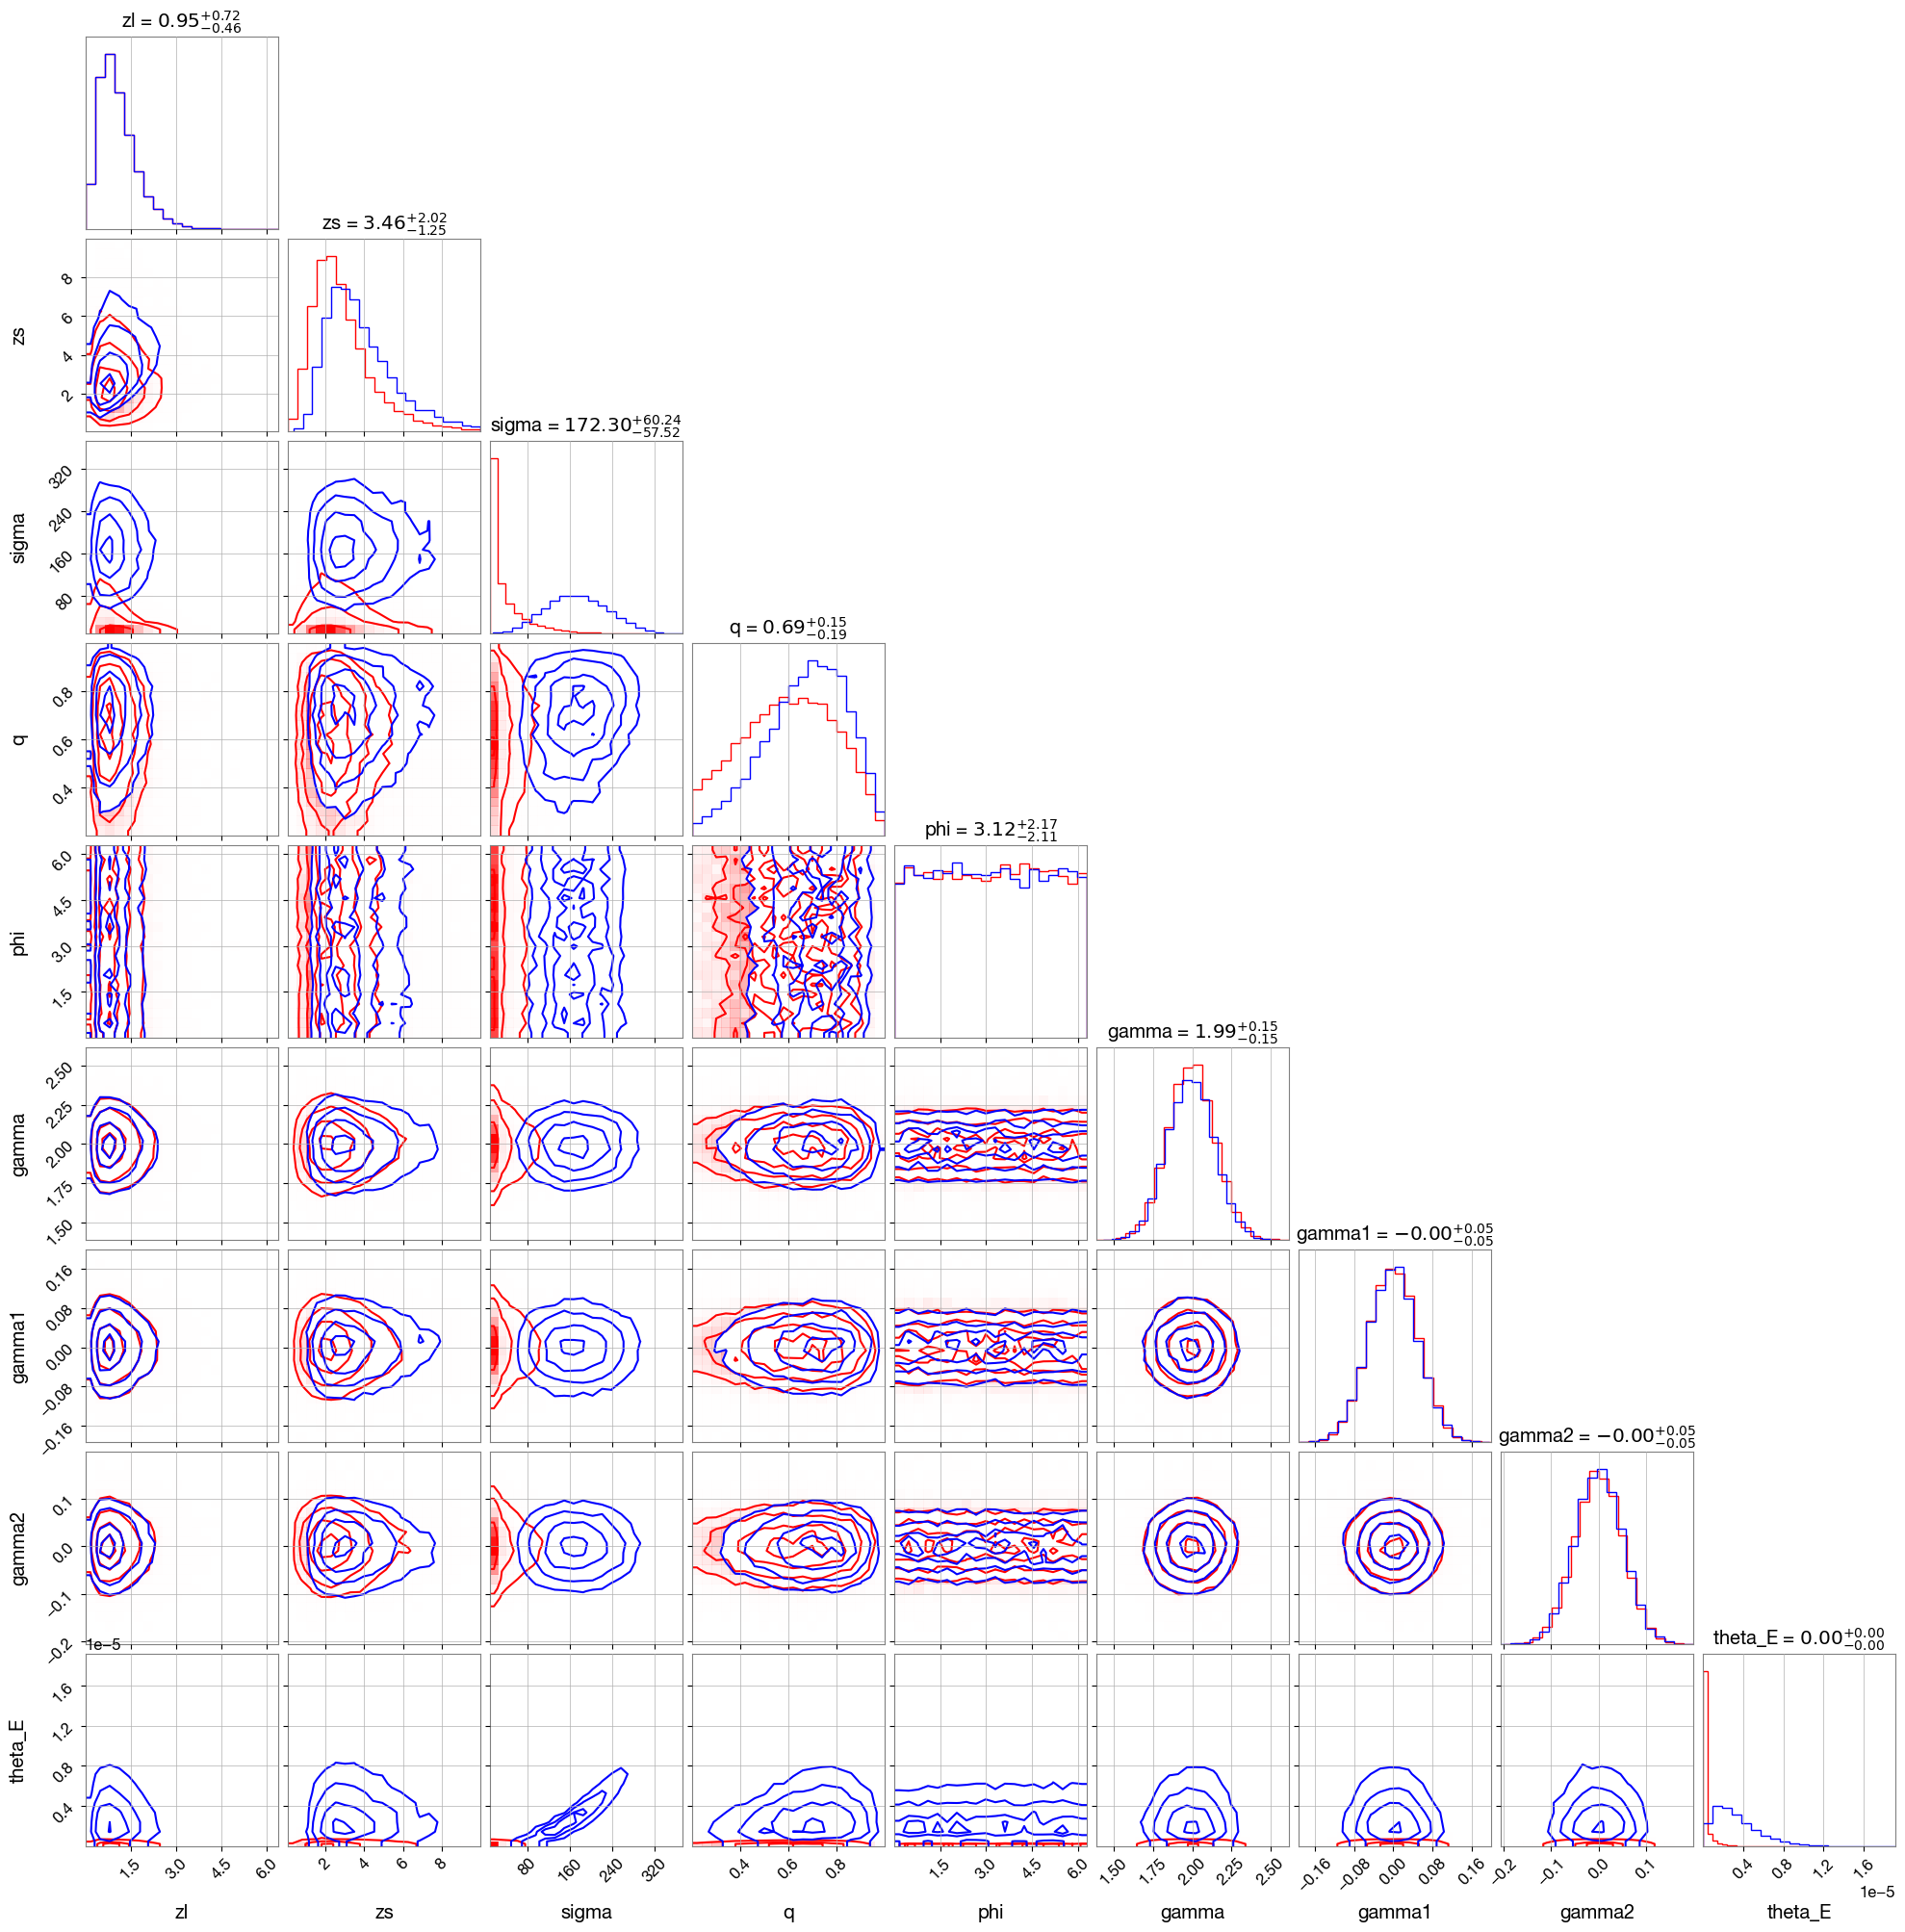

In [32]:
# overlapping corner plot
from corner import corner
import matplotlib.pyplot as plt

name_list = ['zl', 'zs', 'sigma', 'q', 'phi', 'gamma', 'gamma1', 'gamma2', 'theta_E']

sl_list = np.vstack([lens_param[name] for name in name_list]).T
nsl_list = np.vstack([lens_param_nsl[name] for name in name_list]).T

# overlapping corner plot
# avoid scatter points
fig = corner(nsl_list, labels=name_list, show_titles=True, color='red', plot_datapoints=False)
corner(sl_list, labels=name_list, show_titles=True, color='blue', fig=fig, plot_density=False, plot_datapoints=False)
plt.show()

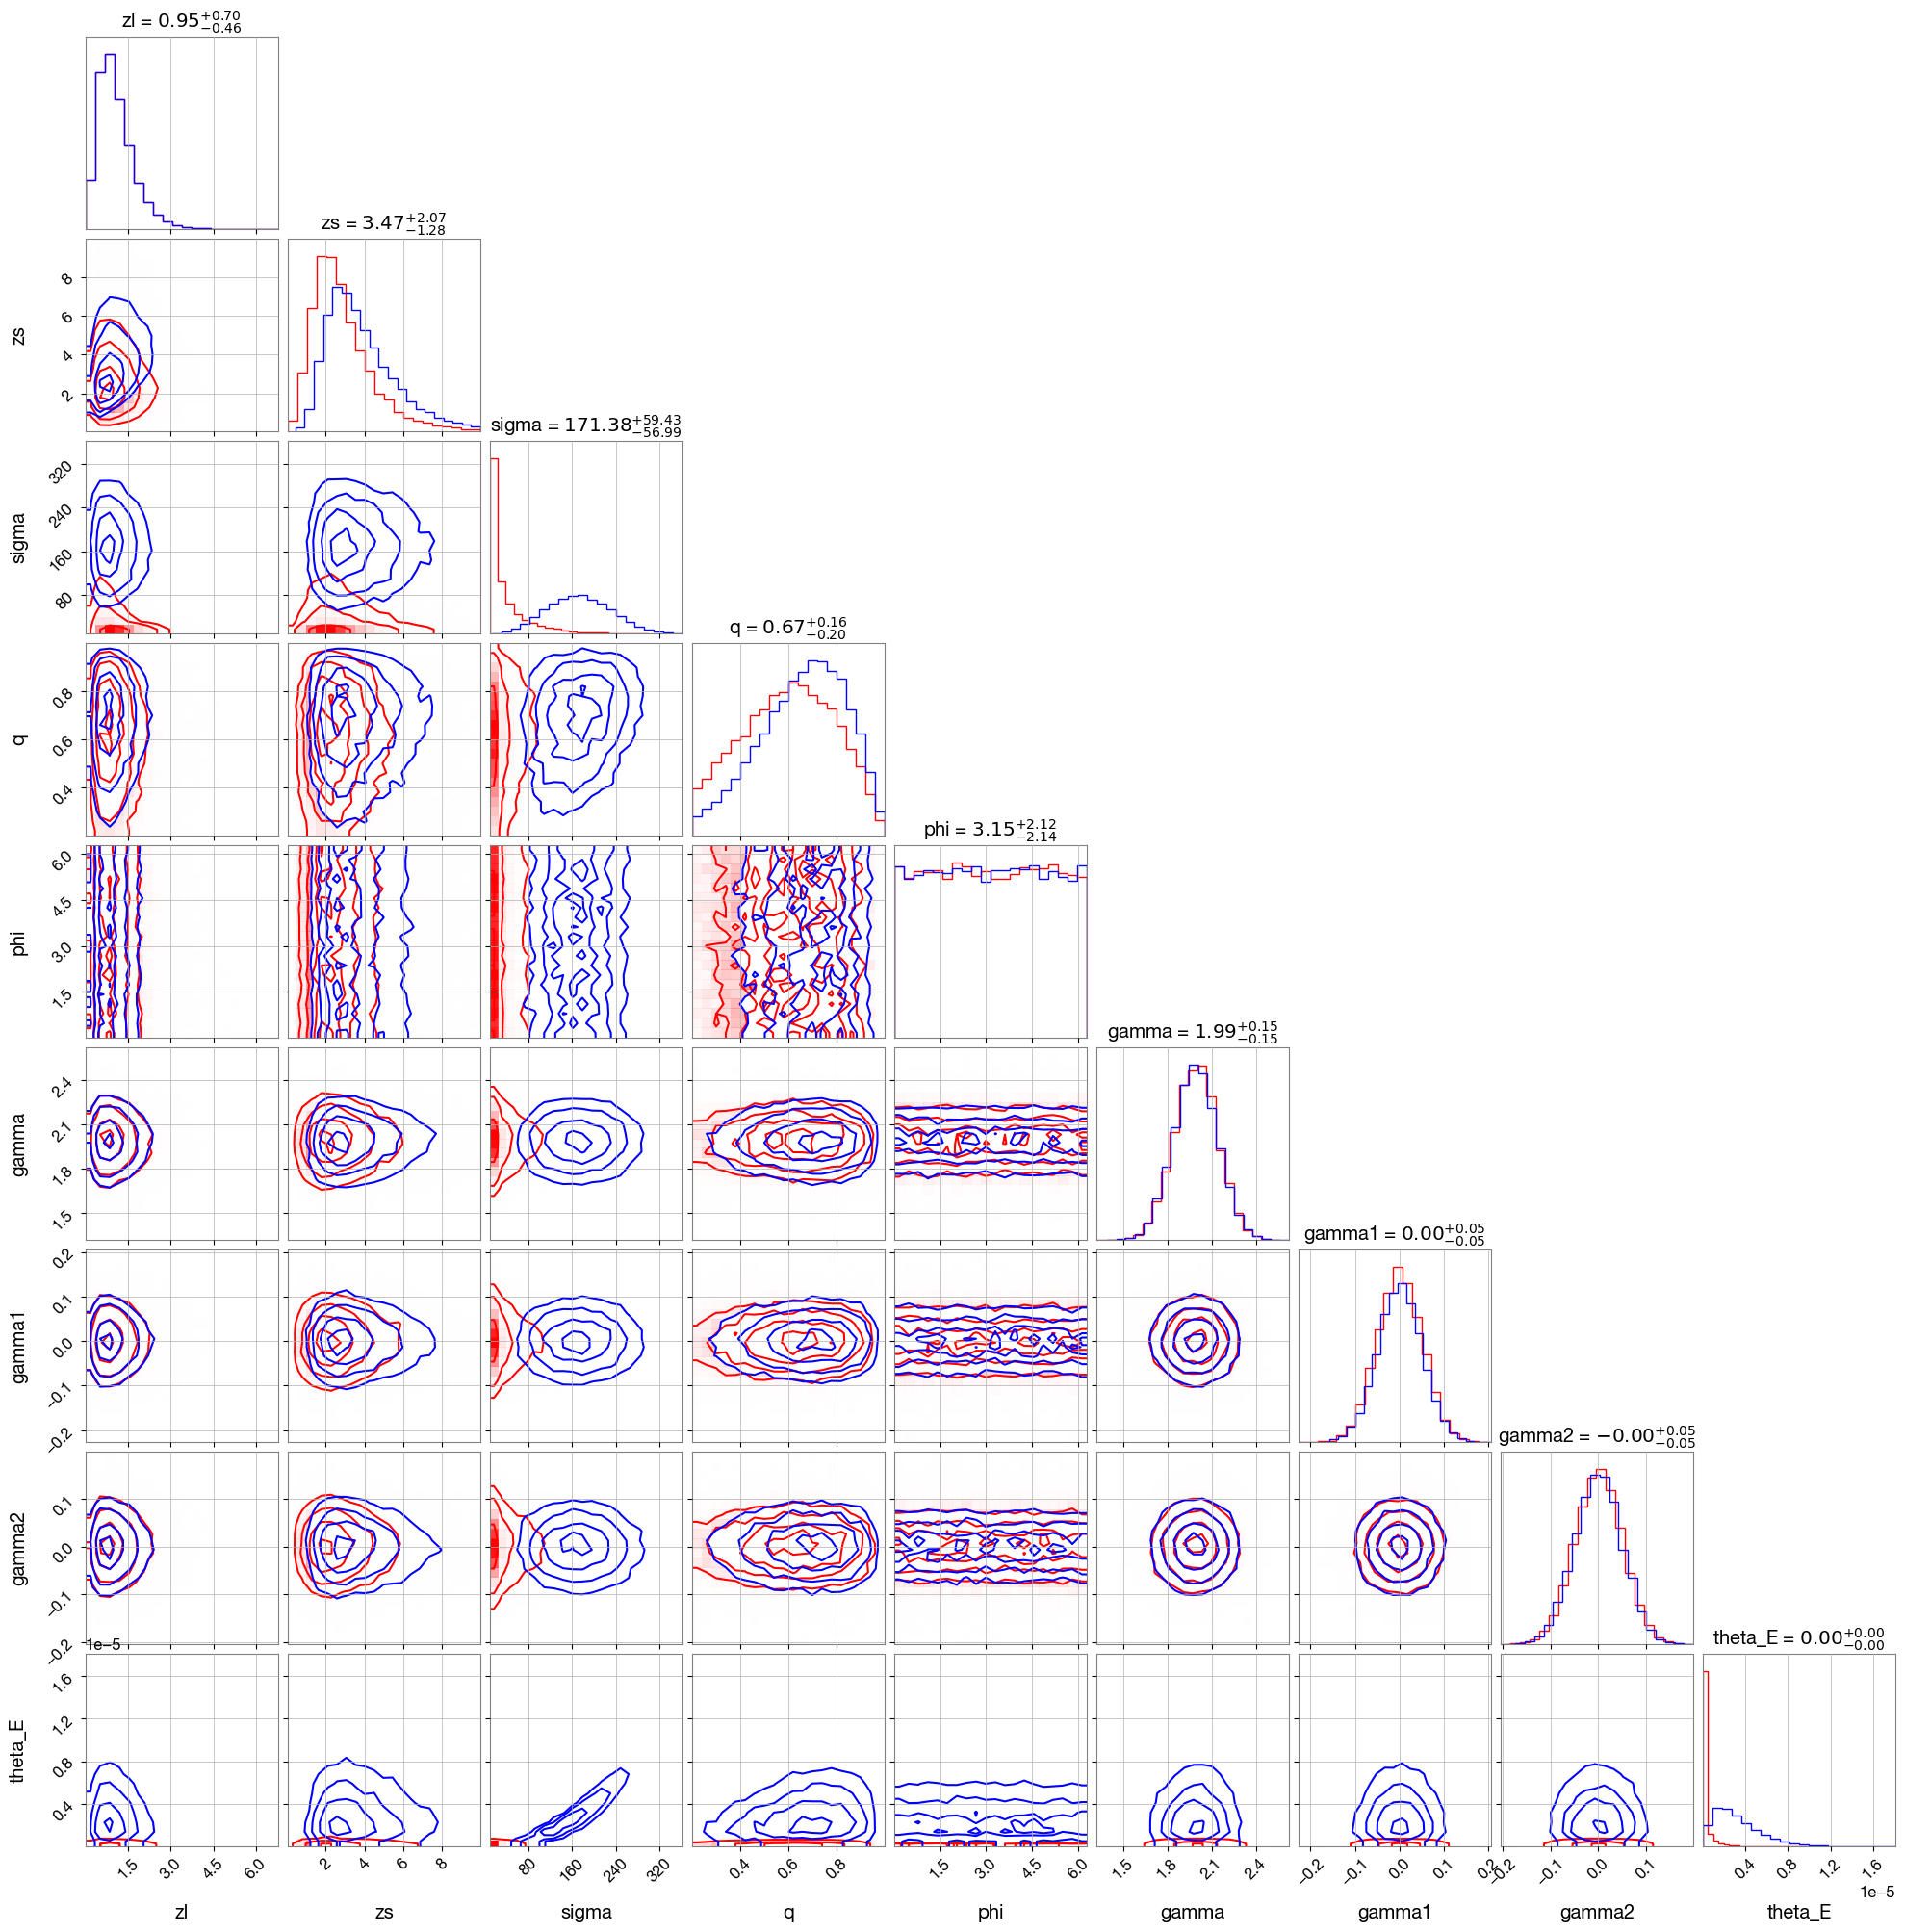

In [26]:
# overlapping corner plot
from corner import corner
import matplotlib.pyplot as plt

name_list = ['zl', 'zs', 'sigma', 'q', 'phi', 'gamma', 'gamma1', 'gamma2', 'theta_E']

sl_list = np.vstack([lens_param[name] for name in name_list]).T
nsl_list = np.vstack([lens_param_nsl[name] for name in name_list]).T

# overlapping corner plot
# avoid scatter points
fig = corner(nsl_list, labels=name_list, show_titles=True, color='red', plot_datapoints=False)
corner(sl_list, labels=name_list, show_titles=True, color='blue', fig=fig, plot_density=False, plot_datapoints=False)
plt.show()

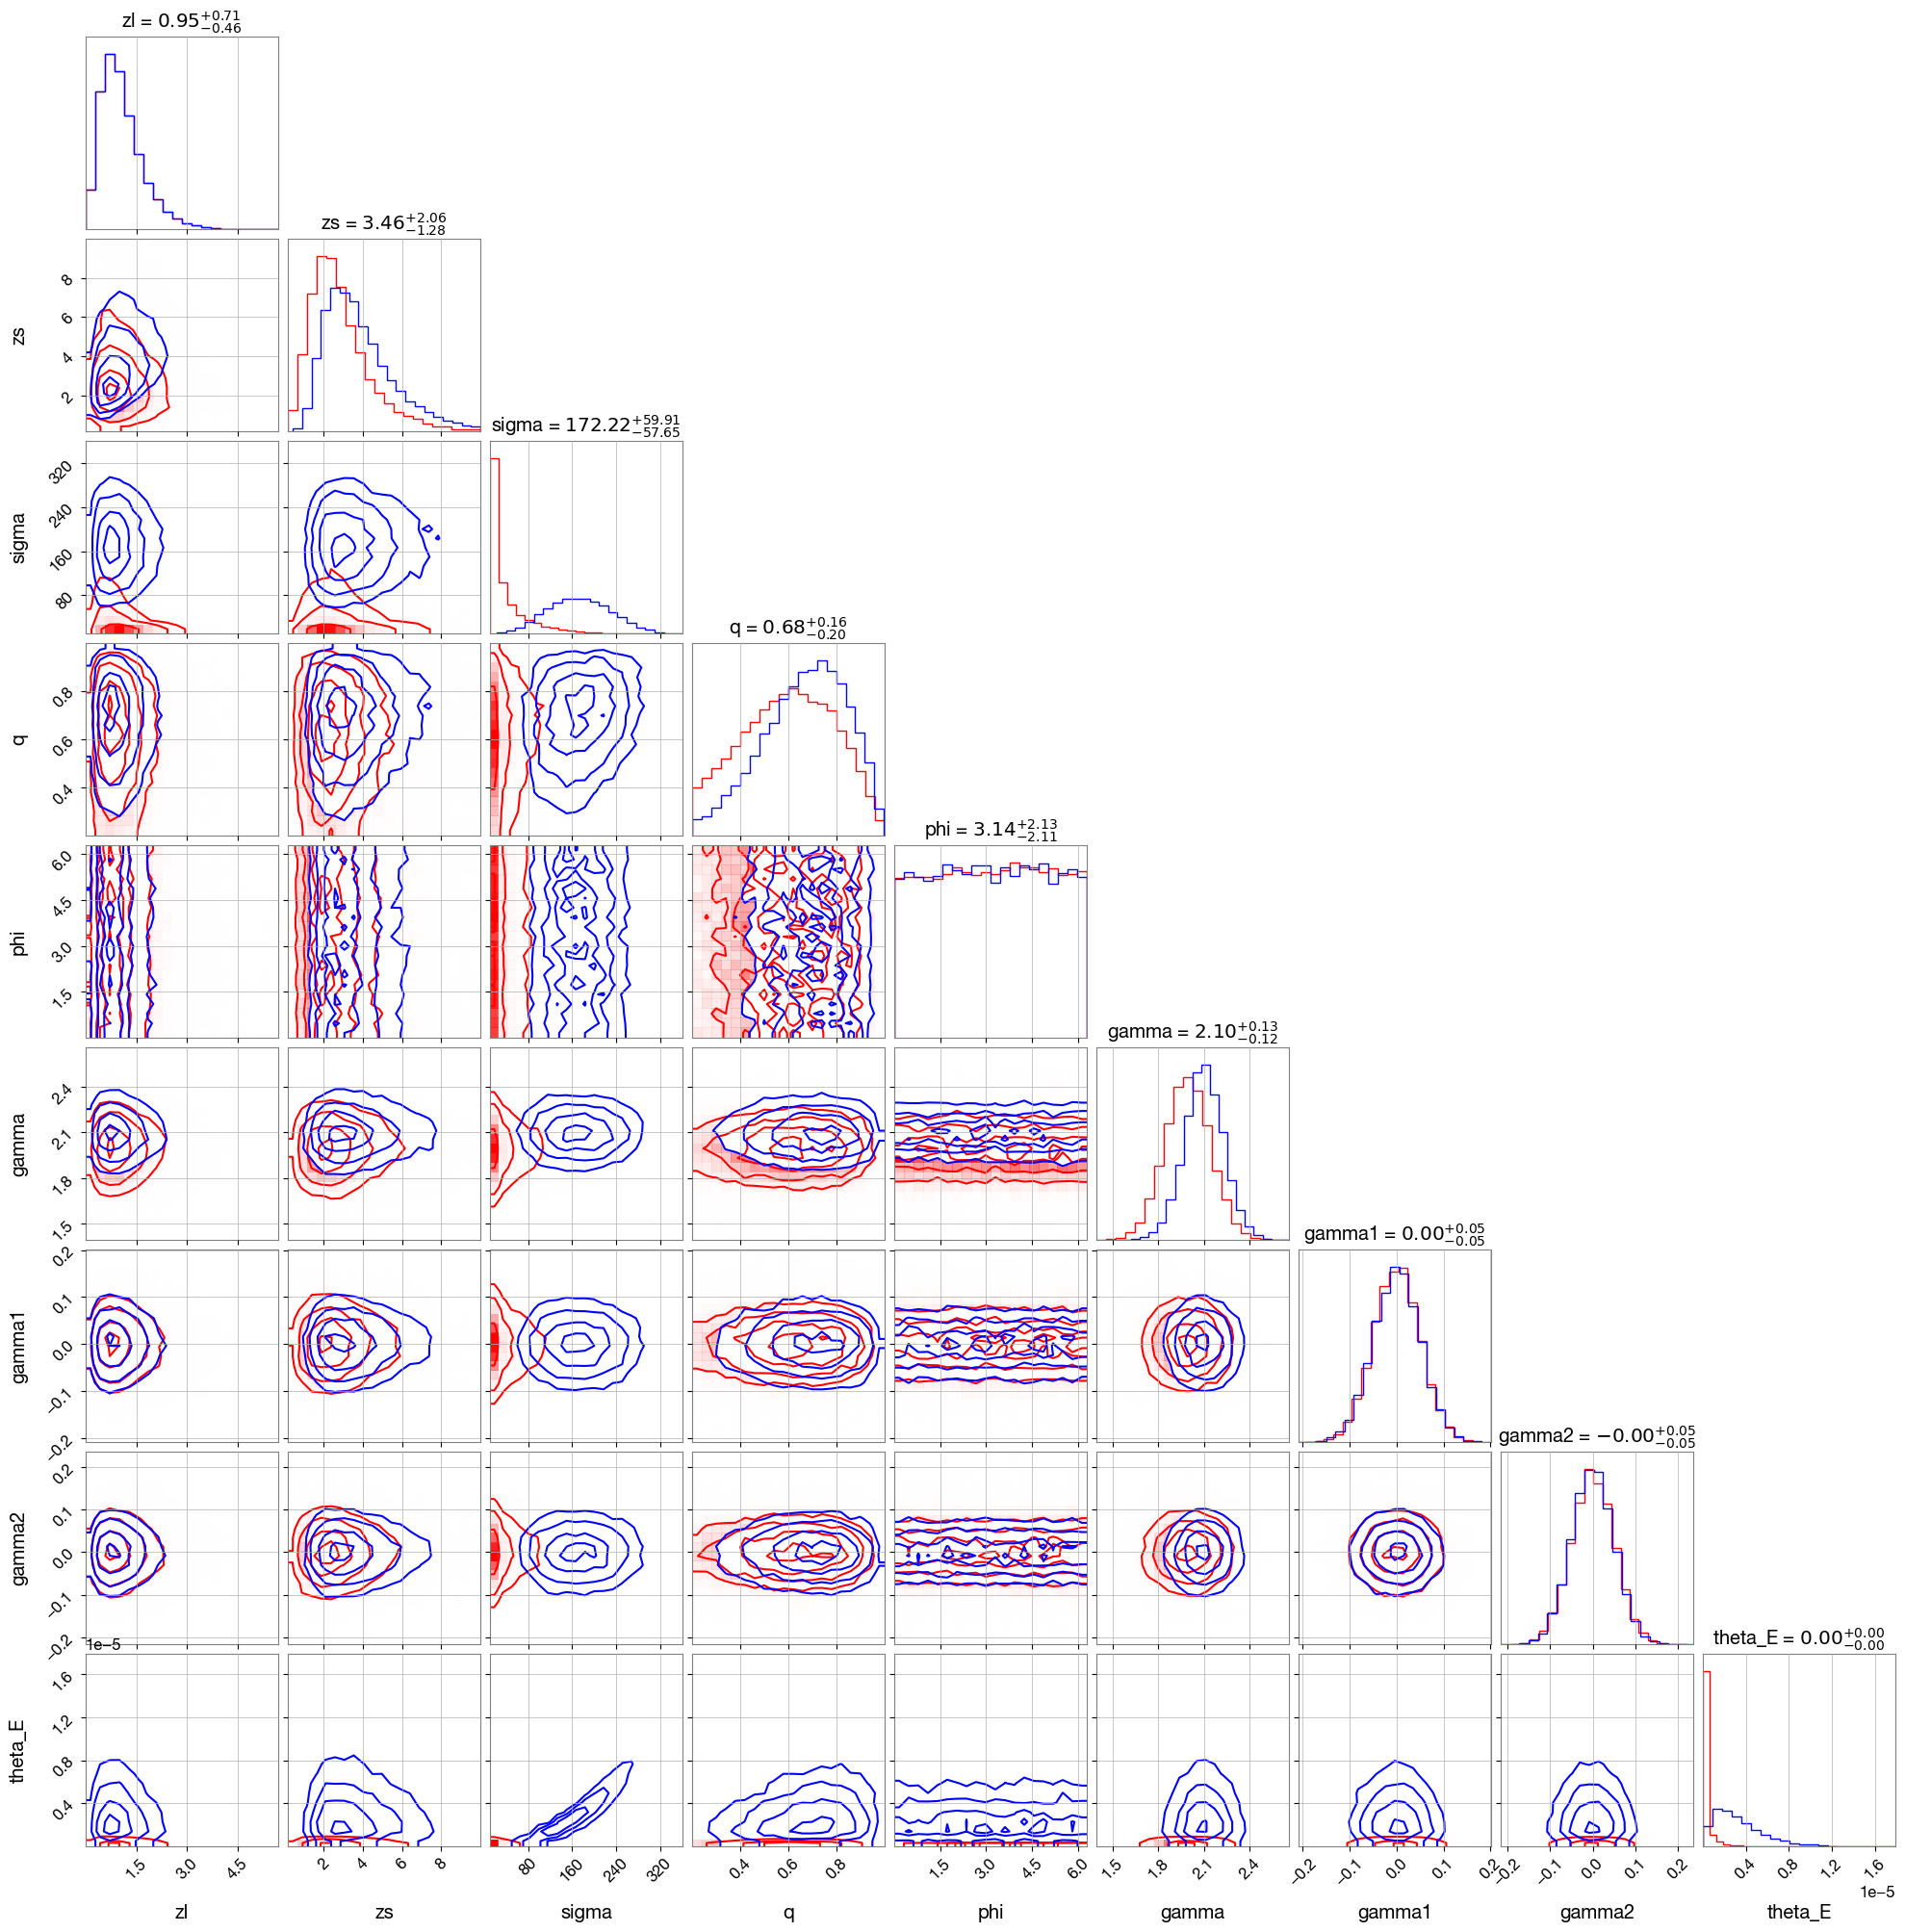

In [38]:
# overlapping corner plot
from corner import corner
import matplotlib.pyplot as plt

name_list = ['zl', 'zs', 'sigma', 'q', 'phi', 'gamma', 'gamma1', 'gamma2', 'theta_E']

sl_list = np.vstack([lens_param[name] for name in name_list]).T
nsl_list = np.vstack([lens_param_nsl[name] for name in name_list]).T

# overlapping corner plot
# avoid scatter points
fig = corner(nsl_list, labels=name_list, show_titles=True, color='red', plot_datapoints=False)
corner(sl_list, labels=name_list, show_titles=True, color='blue', fig=fig, plot_density=False, plot_datapoints=False)
plt.show()

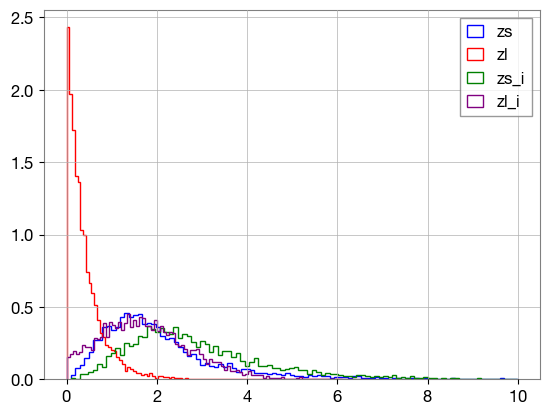

In [24]:
zs = lens_param['zs']
zl = lens_param['zl']
zs_i = lens_param_nsl['zs']
zl_i = lens_param_nsl['zl']

plt.hist(zs, bins=100, histtype='step', color='blue', label='zs', density=True)
plt.hist(zl, bins=100, histtype='step', color='red', label='zl', density=True)
plt.hist(zs_i, bins=100, histtype='step', color='green', label='zs_i', density=True)
plt.hist(zl_i, bins=100, histtype='step', color='purple', label='zl_i', density=True)
plt.legend()
plt.show()

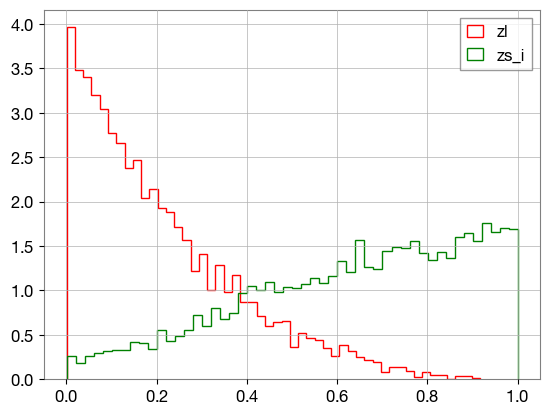

In [10]:
zs = lens_param['zs']
zl = lens_param['zl']
zs_i = lens_param_nsl['zs']
zl_i = lens_param_nsl['zl']

plt.hist(zl/zs, bins=50, histtype='step', color='red', label='zl', density=True)
plt.hist(zl_i/zs_i, bins=50, histtype='step', color='green', label='zs_i', density=True)
plt.legend()
plt.show()

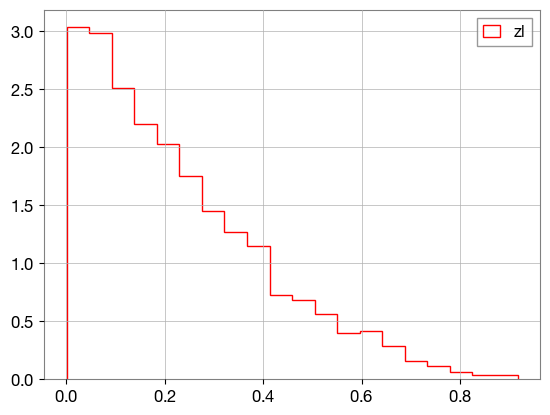

In [15]:
zs = lens_param['zs']
zl = lens_param['zl']
idx = zs<2.0
zs = zs[idx]
zl = zl[idx]


plt.hist(zl/zs, bins=20, histtype='step', color='red', label='zl', density=True)
plt.legend()
plt.show()

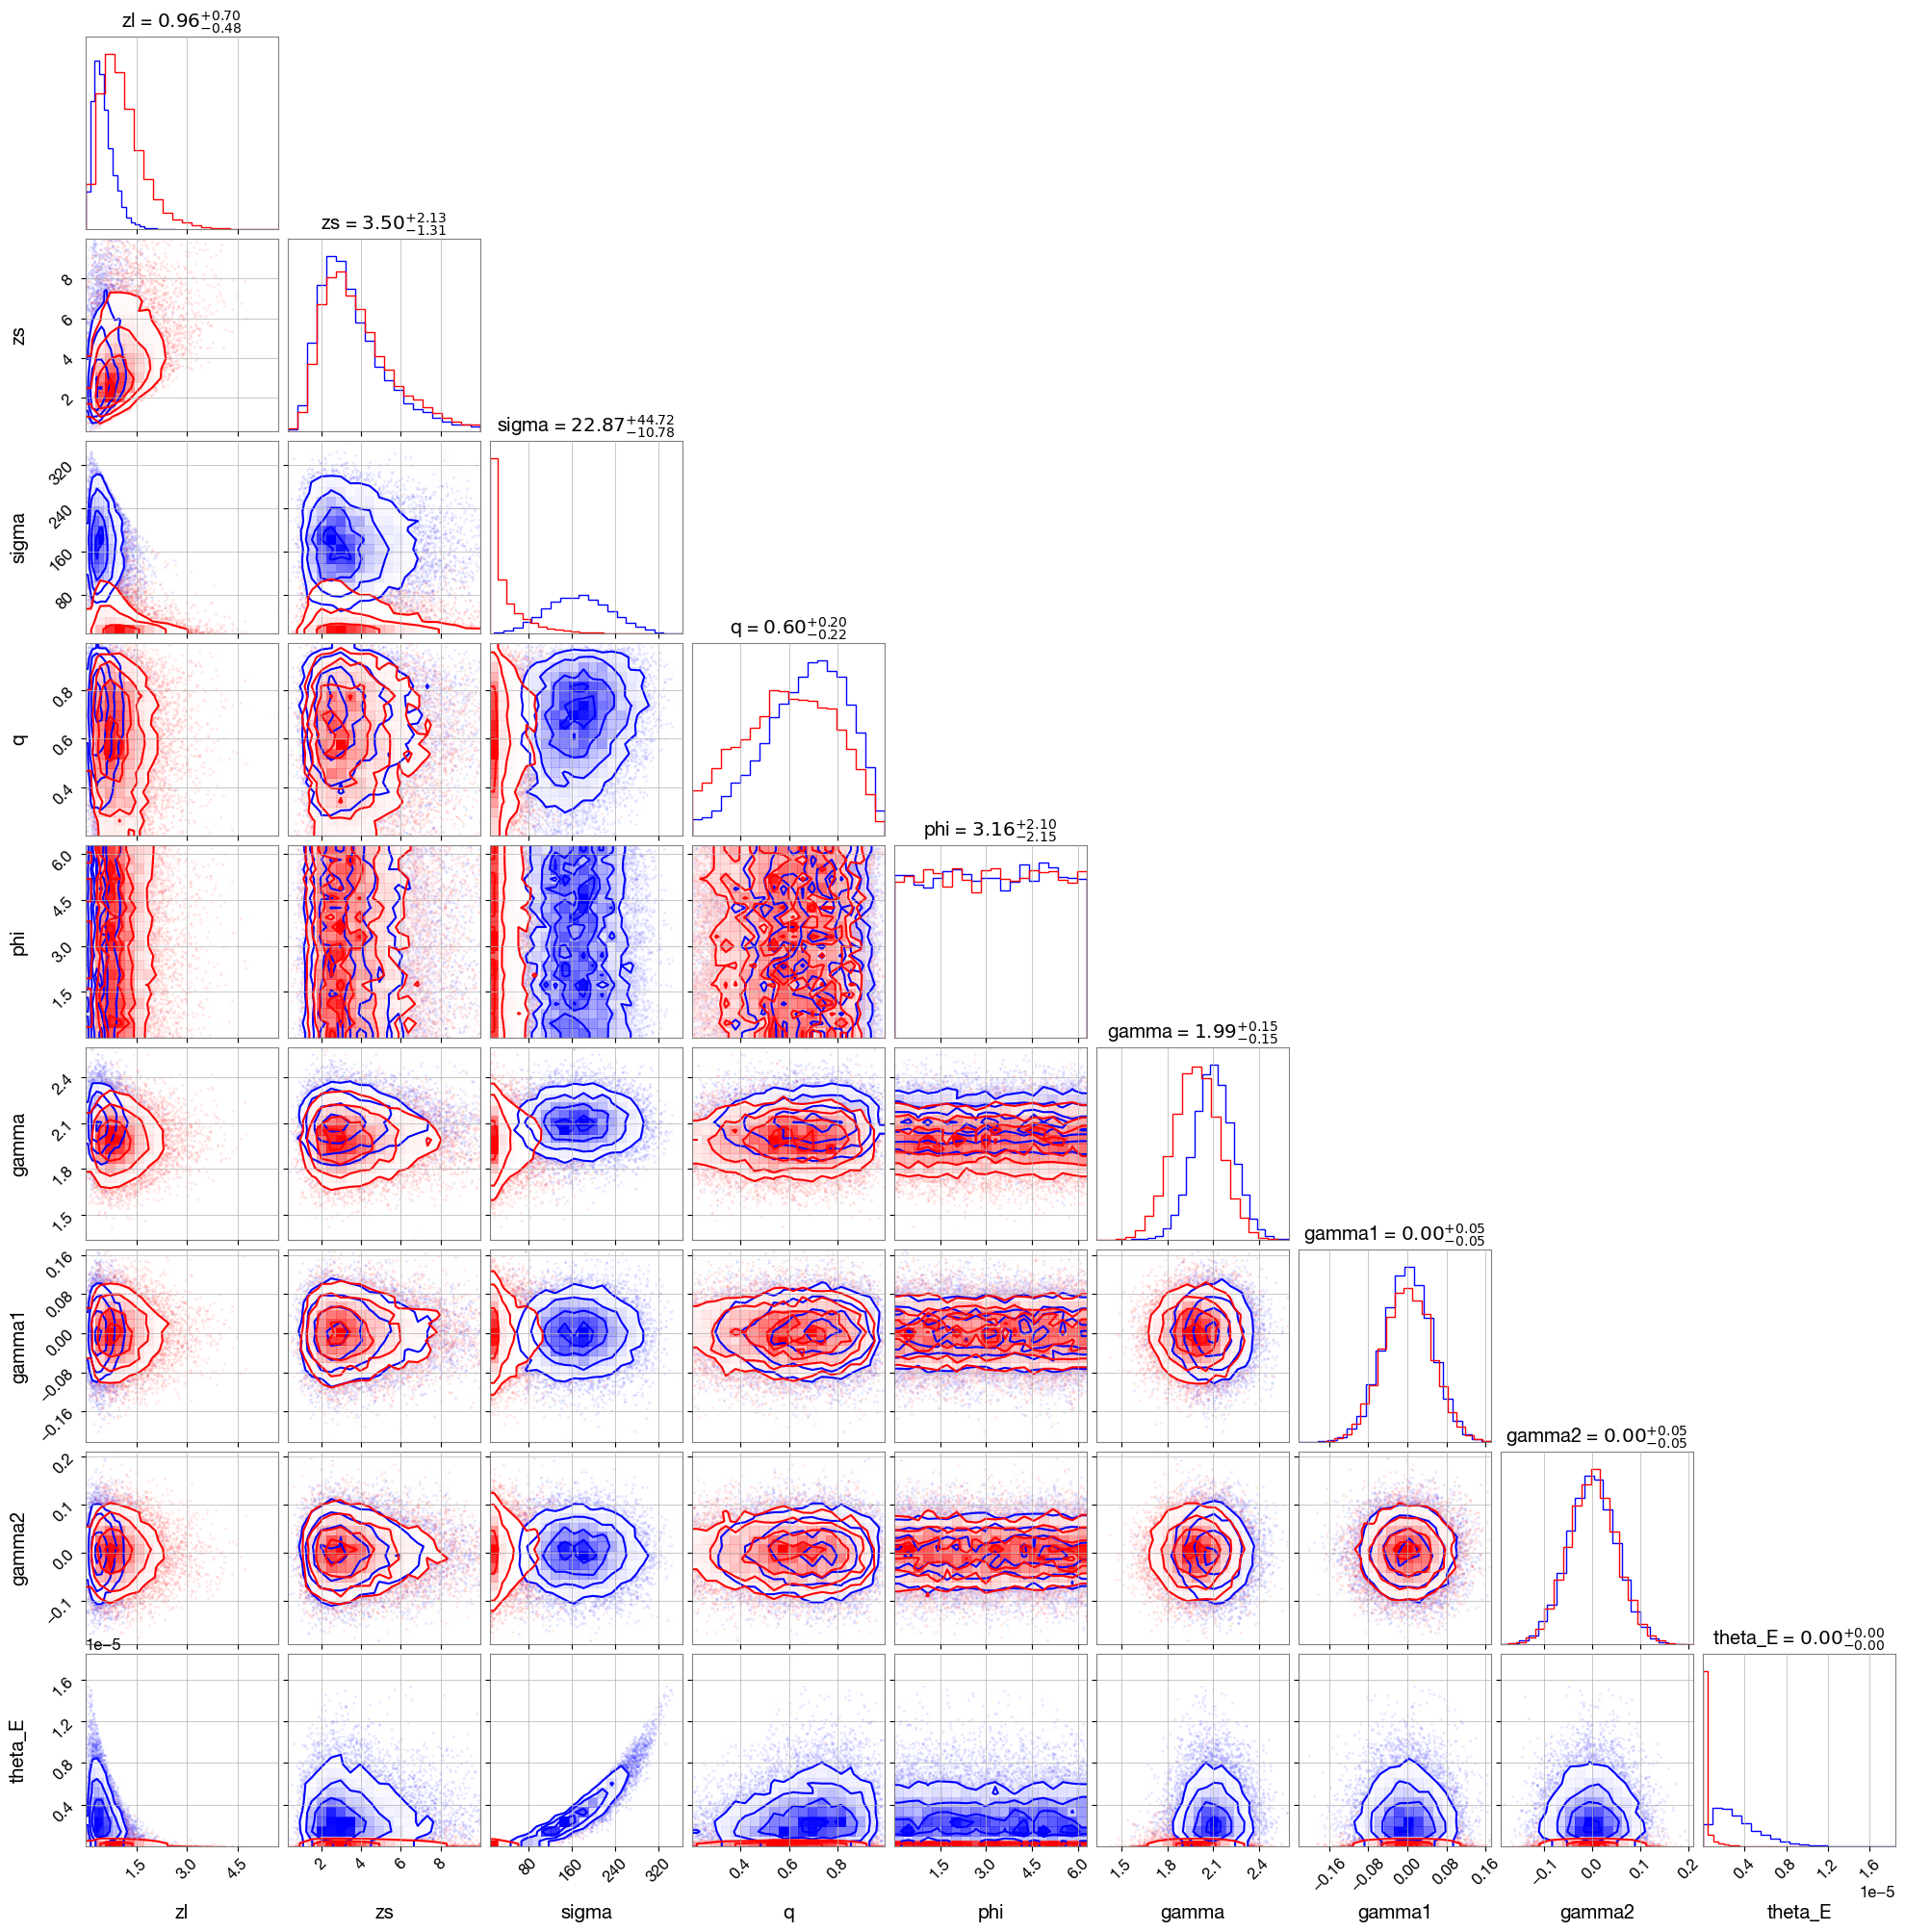

In [11]:
# overlapping corner plot
from corner import corner
import matplotlib.pyplot as plt

name_list = ['zl', 'zs', 'sigma', 'q', 'phi', 'gamma', 'gamma1', 'gamma2', 'theta_E']

sl_list = np.vstack([lens_param[name] for name in name_list]).T
nsl_list = np.vstack([lens_param_nsl[name] for name in name_list]).T

# overlapping corner plot
fig = corner(sl_list, labels=name_list, show_titles=True, color='blue')
corner(nsl_list, labels=name_list, show_titles=True, color='red', fig=fig)
plt.show()

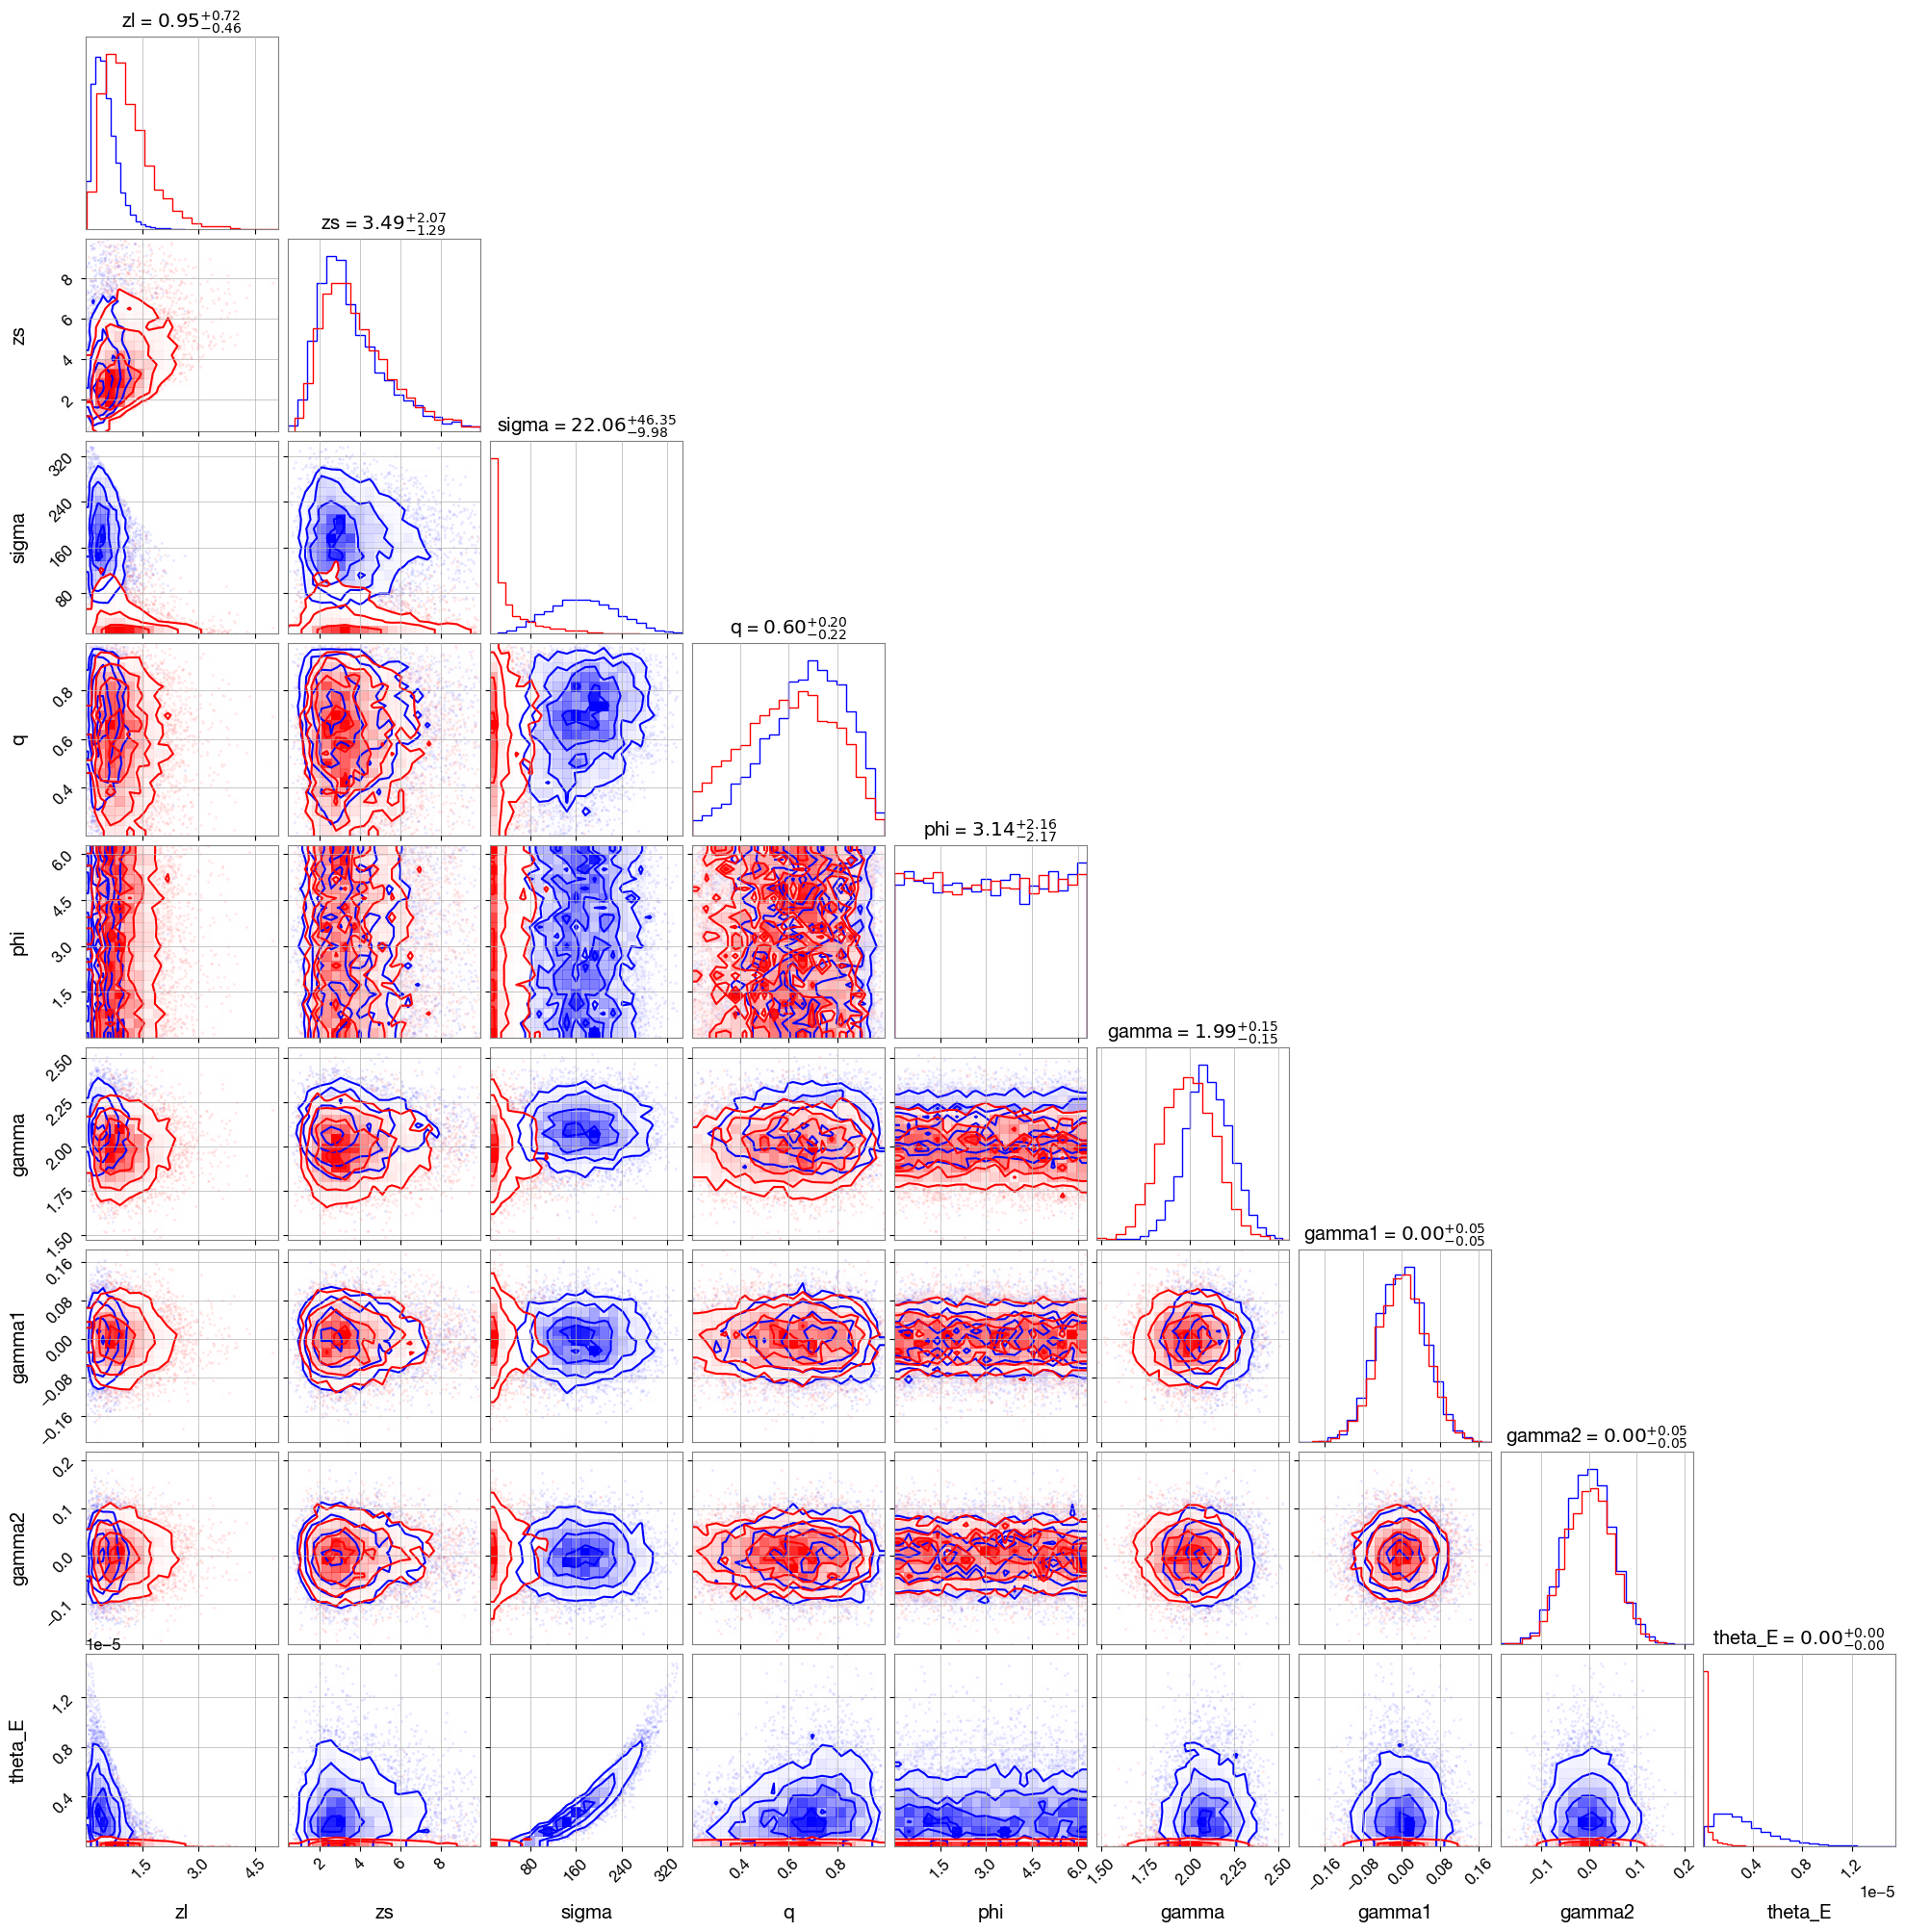

In [20]:
# overlapping corner plot
from corner import corner
import matplotlib.pyplot as plt

name_list = ['zl', 'zs', 'sigma', 'q', 'phi', 'gamma', 'gamma1', 'gamma2', 'theta_E']

sl_list = np.vstack([lens_param[name] for name in name_list]).T
nsl_list = np.vstack([lens_param_nsl[name] for name in name_list]).T

# overlapping corner plot
fig = corner(sl_list, labels=name_list, show_titles=True, color='blue')
corner(nsl_list, labels=name_list, show_titles=True, color='red', fig=fig)
plt.show()

In [19]:
# Haris
from ler.utils import FunctionConditioning
import numpy as np

x = np.linspace(0.0, 1.0, 200)
px = 30*x**2*(1-x)**2

haris = FunctionConditioning(px, x, callback='pdf')

default interpolator will be loaded from ./interpolator_pickle/default/default_2.pickle


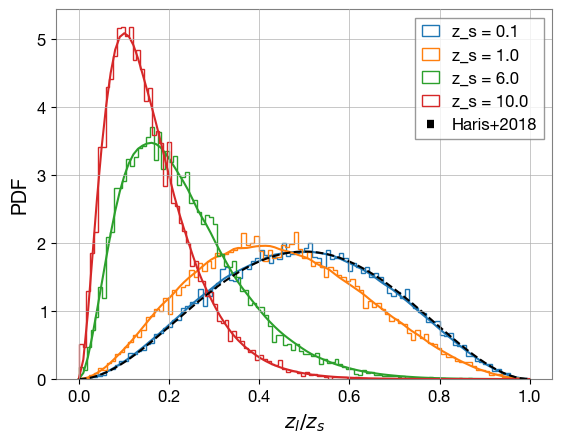

In [20]:
import matplotlib.pyplot as plt
size = 20000
zs_array = np.array([0.1, 1., 6., 10.])
# idx = 0
# plt.hist(od.lens_redshift.rvs(size, zs_array[idx]*np.ones(size)), bins=100, density=True, histtype='step')
# plt.plot(np.linspace(0.0, 1.0, 100), od.lens_redshift.pdf(np.linspace(0.0, 1.0, 100), zs_array[idx]*np.ones(size)))
# plt.show()

for i in range(len(zs_array)):
    plt.hist(ler.lens_redshift.rvs(size, zs_array[i]*np.ones(size))/zs_array[i], bins=100, density=True, histtype='step', label=f'z_s = {zs_array[i]}', color=f'C{i}')
    plt.plot(np.linspace(0.0, 1.0, 100), ler.lens_redshift.pdf(np.linspace(0.0, zs_array[i], 100), zs_array[i]*np.ones(100)), color=f'C{i}')

plt.plot(x, haris(x), label='Haris+2018', linestyle='--', color='k')
plt.xlabel(r'$z_l / z_s$')
plt.ylabel('PDF')
plt.legend()
plt.show()

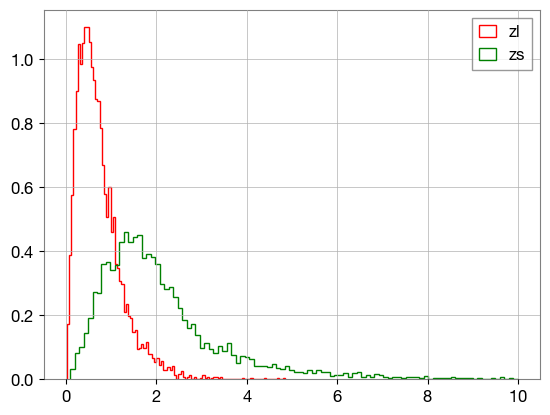

In [26]:
zl =  ler.lens_redshift.rvs(len(zs), zs)

plt.hist(zl, bins=100, histtype='step', color='red', label='zl', density=True)
plt.hist(zs, bins=100, histtype='step', color='green', label='zs', density=True)
plt.legend()
plt.show()

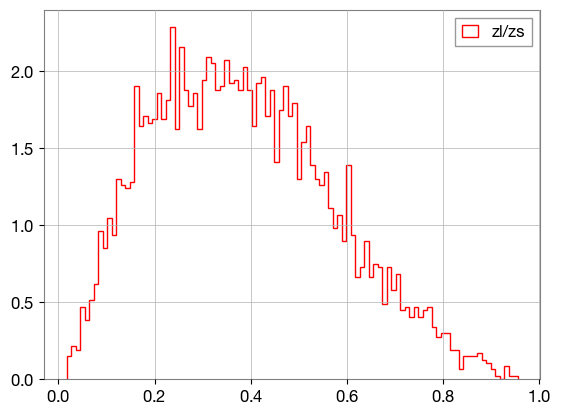

In [27]:
plt.hist(zl/zs, bins=100, histtype='step', color='red', label='zl/zs', density=True)
plt.legend()
plt.show()

In [2]:
zs_array = np.geomspace(0.001, 10.0, 80)
integral = od.optical_depth.function(zs_array)


# integrand = lambda zl, zs: od.lens_redshift.function(np.array([zl]), np.array([zs]))[0]
# integral = []
# for zs in zs_array:
#     integral.append(quad(integrand, 0.0, zs, args=(zs))[0])
# integral = np.array(integral)

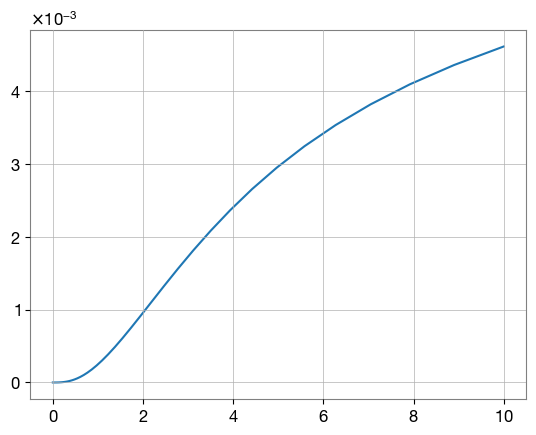

In [3]:
import matplotlib.pyplot as plt
plt.plot(zs_array, integral)

In [21]:
z = 10.
integrand = lambda zl_, zs_: od.lens_redshift.function(np.array([zl_]), np.array([zs_]))[0]
integral = quad(integrand, 0.0, z, args=(z))[0] 
integral

-0.01794095884859826

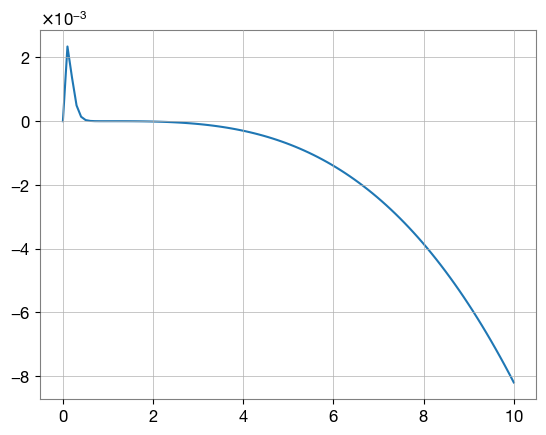

In [22]:
# plot integrand
zs = 10.0
zl = np.linspace(0.0, zs, 100)
plt.plot(zl, od.lens_redshift.function(zl, zs*np.ones_like(zl)))
plt.show()

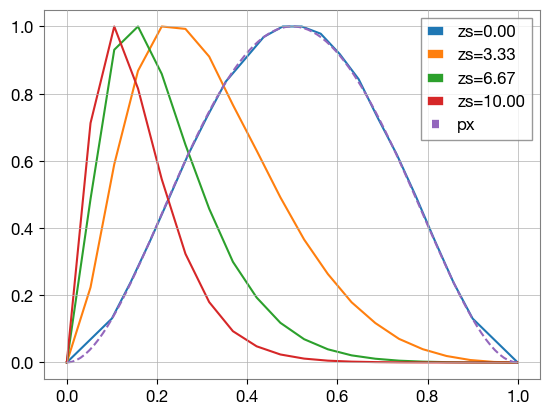

In [8]:
# plot 
import matplotlib.pyplot as plt

# Adding zero at the first element of each row
zl_scaled2d = np.hstack((np.zeros((zl_scaled2d.shape[0], 1)), zl_scaled2d))
density_ = np.hstack((np.zeros((density.shape[0], 1)), density))

# Adding one at the last element of each row of zl_scaled2d
zl_scaled2d = np.hstack((zl_scaled2d, np.ones((zl_scaled2d.shape[0], 1))))

# Adding zero at the last element of each row of density
density_ = np.hstack((density_, np.zeros((density_.shape[0], 1))))


plt.figure()
for i in range(len(zs_array)):
    plt.plot(zl_scaled2d[i], density_[i]/max(density_[i]), label=f'zs={zs_array[i]:.2f}')
x = np.linspace(0.0, 1.0, 100)
px = 30*x**2*(1-x)**2
plt.plot(x, px/max(px), label='px', linestyle='--')
plt.legend()
plt.show()


In [17]:
theta_E, e1, e2, gamma, gamma1, gamma2, q = od.create_data_set(50000)
cs_pred = od.interpolated_cross_section_function(theta_E, e1, e2, gamma, gamma1, gamma2)
cs_true = od.cross_section_caustic_area(theta_E, e1, e2, gamma, gamma1, gamma2)

In [18]:
cs_pred[10:20], cs_true[10:20]

(array([1.24942889e-12, 3.76067944e-13, 1.36661049e-14,
        9.65607352e-13, 1.00730075e-13, 4.83206407e-12,
        2.70752909e-16, 3.64797336e-11, 1.17190401e-12,
        2.68535678e-11]),
 array([1.29481236e-12, 3.66779160e-13, 1.35496876e-14,
        8.97900080e-13, 9.10200345e-14, 4.53509511e-12,
        2.58597469e-16, 3.50989385e-11, 1.21072248e-12,
        2.60442452e-11]))

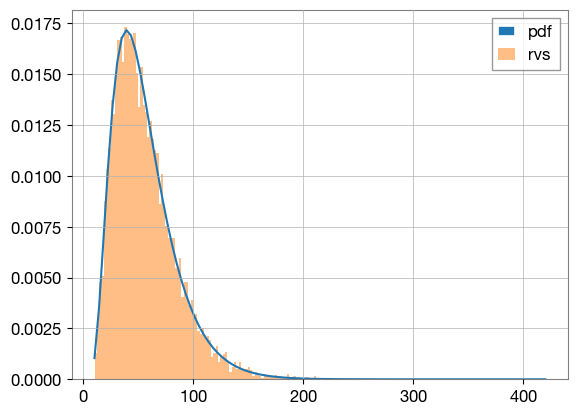

In [3]:
# velocity_dispersion
zl = 6.0
size = 10000
sigma_samples = od.velocity_dispersion.rvs(size, zl)
sigma_array = np.linspace(10.0, 420.0, 100)
sigma_pdf = od.velocity_dispersion.pdf(sigma_array, zl*np.ones_like(sigma_array))

# plot
import matplotlib.pyplot as plt
plt.plot(sigma_array, sigma_pdf, label='pdf')
plt.hist(sigma_samples, bins=100, density=True, alpha=0.5, label='rvs')
plt.legend()
plt.show()

In [4]:
od.axis_ratio

'axis_ratio_rayleigh'

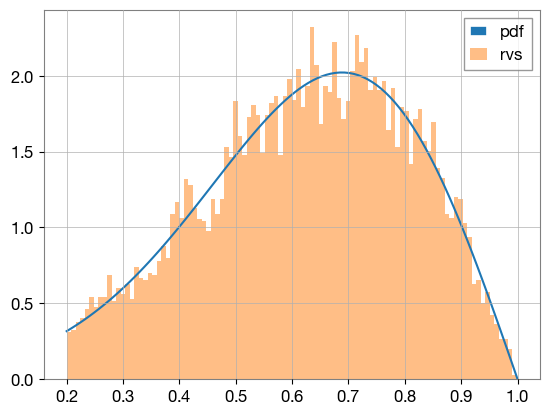

In [4]:
# axis_ratio
sigma = 120.
size = 10000
axis_ratio_samples = od.axis_ratio.rvs(size, sigma)
axis_ratio_array = np.linspace(0.2, 1.0, 100)
axis_ratio_pdf = od.axis_ratio.pdf(axis_ratio_array, sigma*np.ones_like(axis_ratio_array))

# plot
import matplotlib.pyplot as plt
plt.plot(axis_ratio_array, axis_ratio_pdf, label='pdf')
plt.hist(axis_ratio_samples, bins=100, density=True, alpha=0.5, label='rvs')
plt.legend()
plt.show()

In [3]:
zs = np.linspace(0.001, 10.0, 4)
# y_array1 = np.linspace(0.001, 10, 100)
# y_array2 = np.geomspace(0.001, 10, 100)
# unique
# zs = np.unique(np.concatenate([y_array1, y_array2]))

zs = np.array([zs]).reshape(-1)
#no = od.sampler_priors_params["velocity_dispersion"]["phistar"]
sigma_args = od.sampler_priors_params["velocity_dispersion"]
sigma_args = [
    sigma_args["vd_min"],
    sigma_args["vd_max"],
    sigma_args["alpha"],
    sigma_args["beta"],
    sigma_args["phistar"],
    sigma_args["sigmastar"],
]
splinedVcdz = od.splinedVcdz
splineDa = od.splineDa
idx = np.arange(len(zs))

input_params = np.array([(zs[i], sigma_args, splineDa, splinedVcdz, idx[i], od.sample_axis_ratio, od.cross_section_function) for i in range(len(zs))], dtype=object)

In [4]:
print("Computing lens redshift distribution with multiprocessing...")
zl_len = 20
zl_array = np.zeros((len(zs), zl_len))
zl_pdf = np.zeros((len(zs), zl_len))
# # with tqdm
tau_list = np.ones(len(zs))
with Pool(processes=od.npool) as pool:            
    for result in tqdm(
        pool.imap_unordered(lens_redshift_epl_shear1_mp, input_params),
        total=len(zs),
        ncols=100,
        disable=False,
    ):
        # print(result)
        (
            iter_i,
            zl_array_,
            zl_pdf_,
        ) = result

        zl_array[iter_i] = zl_array_
        zl_pdf[iter_i] = zl_pdf_

Computing lens redshift distribution with multiprocessing...


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:45<00:00, 11.34s/it]


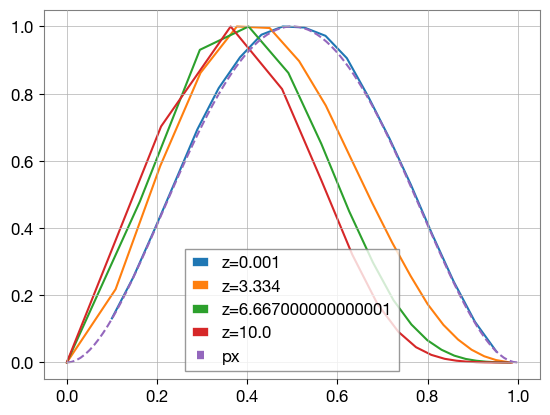

In [6]:
# plot 
import matplotlib.pyplot as plt

plt.figure()
for i in range(len(zs)):
    dcl = od.z_to_Dc(zl_array[i])
    dcs = od.z_to_Dc(np.array([zs[i]]))[0]
    result_ = zl_pdf[i]/max(zl_pdf[i])
    plt.plot(dcl/dcs, result_/max(result_), label=f'z={zs[i]}')
x = np.linspace(0.0, 1.0, 100)
px = 30*x**2*(1-x)**2
plt.plot(x, px/max(px), label='px', linestyle='--')
plt.legend()
plt.show()

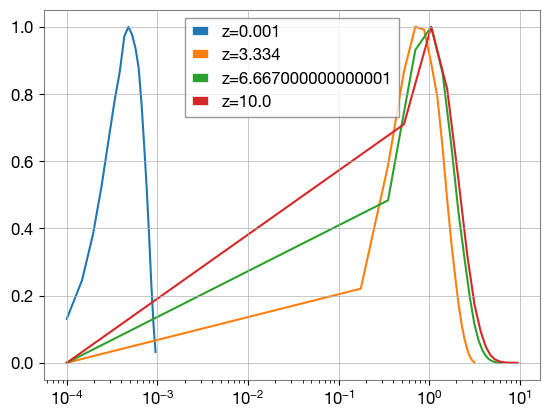

In [9]:
# plot 
import matplotlib.pyplot as plt
plt.figure()
for i in range(len(zs)):
    plt.plot(zl_array[i], zl_pdf[i]/max(zl_pdf[i]), label=f'z={zs[i]}')
plt.xscale('log')
plt.legend()
plt.show()

In [14]:
import matplotlib.pyplot as plt

zs = np.linspace(0.001, 10.0, 4)
zl_len = 20
zl_array = np.zeros((len(zs), zl_len))
for i, z in enumerate(zs):
    zl_array[i] = np.linspace(0.0001, z, zl_len)

In [18]:
dcs, dcl

(858.2045114909307,
 array([4.28223731e-01, 1.29348373e+03, 1.67101715e+03,
        1.74745108e+03, 1.71586560e+03, 1.64571393e+03,
        1.56401930e+03, 1.48173921e+03, 1.40328039e+03,
        1.33023919e+03, 1.26297572e+03, 1.20131111e+03,
        1.14484716e+03, 1.09311525e+03, 1.04564520e+03,
        1.00199547e+03, 9.61764816e+02, 9.24594750e+02,
        8.90167897e+02, 8.58204511e+02]))

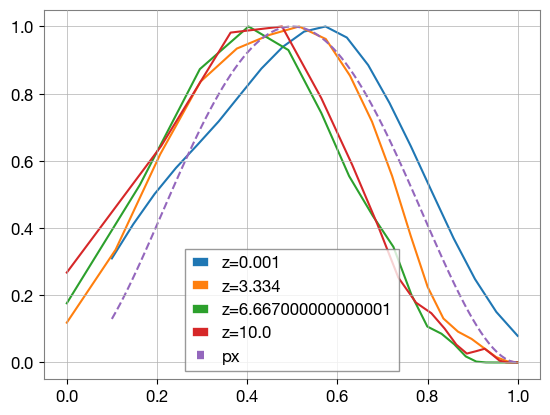

In [20]:
plt.figure()
for i in range(len(zs)):
    dcl = od.z_to_Dc(zl_array[i])
    dcs = od.z_to_Dc(np.array([zs[i]]))[0]
    result_ = test2.pdf(zl_array[i], zs[i]*np.ones(zl_len))
    plt.plot(dcl/dcs, result_/max(result_), label=f'z={zs[i]}')
x = np.linspace(0.1, 1.0, 100)
px = 30*x**2*(1-x)**2
plt.plot(x, px/max(px), label='px', linestyle='--')
plt.legend()
plt.show()

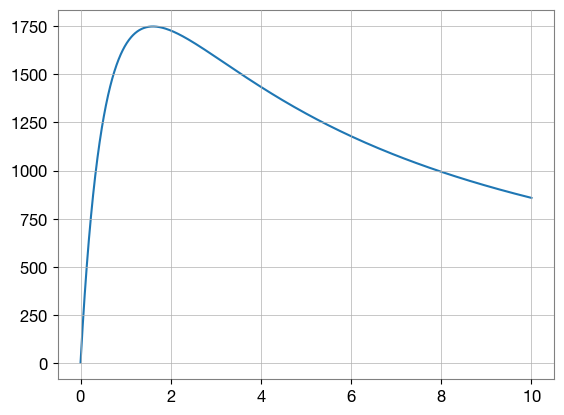

In [8]:
plt.plot(x_array, z_array)
plt.show()

In [3]:
5.7e-4*161.

0.09176999999999999

In [11]:
# 1D sucess, loading and saving also works
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
Da = lambda z_: cosmo.angular_diameter_distance(z_).value
x_array = np.geomspace(0.001, 10.0, 1000)
z_array = Da(x_array)

test = FuntionConditioning(
    param_dict_given={'dimension': 1},
    function=Da,
    x_array=x_array,
    # conditioned_y_array=y_array,
    create_new=True,
    npool=4,
)
# test2 = FuntionConditioning(
#     param_dict_given={'dimension': 2},
#     function=z_array,
#     x_array=x_array,
#     conditioned_y_array=y_array,
#     create_new=True,
# )

# pdf_func_ = lambda vd_, zl_: phi(vd_, zl_)
# test3 = FuntionConditioning(
#     param_dict_given={'dimension': 2},
#     function=pdf_func_,
#     x_array=np.linspace(10., 420., 100),
#     conditioned_y_array=np.linspace(0.001, 10., 100),
#     create_new=True,
# )

default interpolator will be generated at ./interpolator_pickle/default/default_1.pickle


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]


AttributeError: Can't pickle local object 'FuntionConditioning.create_z_array.<locals>.function_mp'

In [43]:
np.sum(test3.z_array<0.)

0

In [10]:
test2.pdf(np.array([0.1,1.112, 2., 2.223]), np.array([0.1,1.112, 2., 2.223]))

[0.6738069998937135,
 0.02119324713282822,
 0.016741475435082975,
 0.016333048279193463]

In [20]:
y = test2.conditioned_y_array
ynew = 0.01

y_idx = np.searchsorted(y, ynew) - 1 if ynew > y[0] else 0
if ynew > y[y_idx] + (y[y_idx+1] - y[y_idx]) / 2:
    y_idx = y_idx + 1

print(y_idx, y[y_idx], ynew)

0 0.001 0.01


In [25]:
cubic_spline_interpolator(np.linspace(0.0, 0.01, 100), test2.function_spline[y_idx], test2.x_array[y_idx])

SyntaxError: incomplete input (3513201128.py, line 1)

In [12]:
y1d = test2.conditioned_y_array
conditioned_y = 1.0
y_idx = np.searchsorted(y1d, conditioned_y) - 1 if conditioned_y > y1d[0] else 0
print(y_idx)

cdf2d = test2.cdf_values
x2d = test2.x_array
cdf = cdf2d[y_idx]
x = x2d[y_idx]

size = 10
u = np.random.uniform(0, 1, size)
idx = np.searchsorted(cdf, u)
# x1, x0, y1, y0 = cdf[idx], cdf[idx-1], x[idx], x[idx-1]
# samples = y0 + (y1 - y0) * (u - x0) / (x1 - x0)
u, idx

9


(array([0.8287399 , 0.21013327, 0.86829262, 0.37377619,
        0.50097759, 0.18257978, 0.07358526, 0.97963767,
        0.19944918, 0.69241226]),
 array([67, 26, 70, 36, 42, 24, 15, 86, 26, 55]))

In [30]:
test2.x_array[y_idx].min(), test2.x_array[y_idx].max()

(0.0, 0.001)

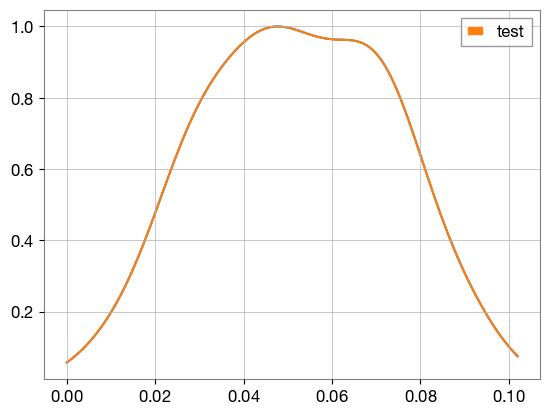

In [46]:
y_idx = 1
# plt.plot(test2.x_array[y_idx],test2.cdf_values[y_idx])
plt.plot(test2.x_array[y_idx],test2.z_array[y_idx])

spline = CubicSpline(test2.x_array[y_idx], test2.z_array[y_idx]).c

plt.plot(test2.x_array[y_idx], cubic_spline_interpolator(np.linspace(0.0, test2.conditioned_y_array[y_idx], 100), spline, test2.x_array[y_idx]), label='test')
plt.legend()


plt.show()

In [10]:
# integrate test2.pdf with quad
y_idx = 0
y = test2.conditioned_y_array[y_idx]
integrand = lambda x: test2.pdf(np.array([x]), np.array([y]))[0]

quad(integrand, 0.0, y)

(1.0000000088986405, 1.0460726803139762e-08)

In [9]:
test2.conditioned_y_array

array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03,
       1.32194115e-03, 1.45082878e-03, 1.59228279e-03,
       1.74752840e-03, 1.91791026e-03, 2.10490414e-03,
       2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03,
       4.03701726e-03, 4.43062146e-03, 4.86260158e-03,
       5.33669923e-03, 5.85702082e-03, 6.42807312e-03,
       7.05480231e-03, 7.74263683e-03, 8.49753436e-03,
       9.32603347e-03, 1.02353102e-02, 1.12332403e-02,
       1.23284674e-02, 1.35304777e-02, 1.48496826e-02,
       1.62975083e-02, 1.78864953e-02, 1.96304065e-02,
       2.15443469e-02, 2.36448941e-02, 2.59502421e-02,
       2.84803587e-02, 3.12571585e-02, 3.43046929e-02,
       3.76493581e-02, 4.13201240e-02, 4.53487851e-02,
       4.97702356e-02, 5.46227722e-02, 5.99484250e-02,
       6.57933225e-02, 7.22080902e-02, 7.92482898e-02,
       8.69749003e-02, 9.54548457e-02, 1.02000000e-01,
       1.04761575e-01, 1.14975700e-01, 1.26185688e-01,
       1.3

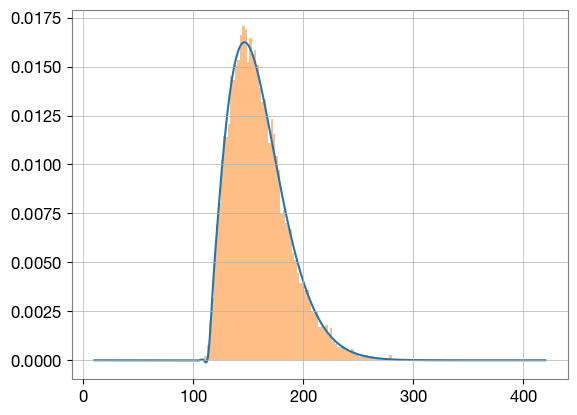

In [61]:
x_values = np.linspace(10.0, 420.0, 1000)
plt.plot(x_values, test3.pdf(x_values,10.0*np.ones_like(x_values)), label='zl=10')
plt.hist(test3.rvs(20000, 10.0), bins=100, density=True, alpha=0.5, label='rvs')
plt.show()

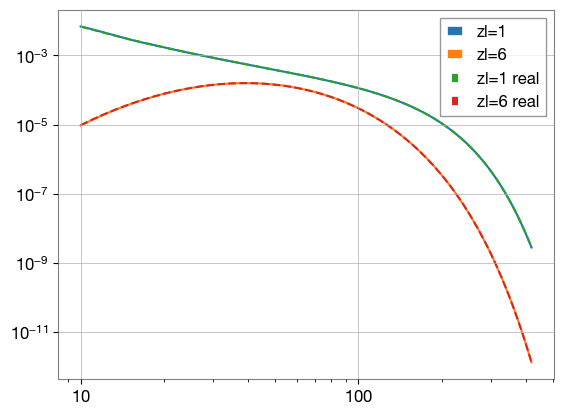

In [62]:
x_values = np.linspace(10.0, 420.0, 1000)
#test.function(x_values)
plt.plot(x_values, test3.function(x_values, 1.0*np.ones_like(x_values)), label='zl=1')
plt.plot(x_values, test3.function(x_values,6.0*np.ones_like(x_values)), label='zl=6')
plt.plot(x_values, pdf_func_(x_values, 1.0*np.ones_like(x_values)), '--', label='zl=1 real')
plt.plot(x_values, pdf_func_(x_values, 6.0), '--', label='zl=6 real')
# plt.plot(x_values, test2.function(x_values, test2.conditioned_y_array[1]*np.ones_like(x_values)), label='function')
#plt.hist(test3.rvs(20000, 1.0), bins=100, density=True, alpha=0.5, label='rvs')

# x_max = test2.conditioned_y_array[2]
# x_values = np.linspace(0.0, x_max, 100)
# plt.plot(x_values, test2.function(x_values, x_max*np.ones_like(x_values)), label='function2')

# idx = np.searchsorted(y_array, x_max)
#plt.plot(x_array[idx], z_array[idx], 'o', label='data')
# plt.xlim(50., 100.0)
# plt.ylim(0.0, 3.0e-4)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

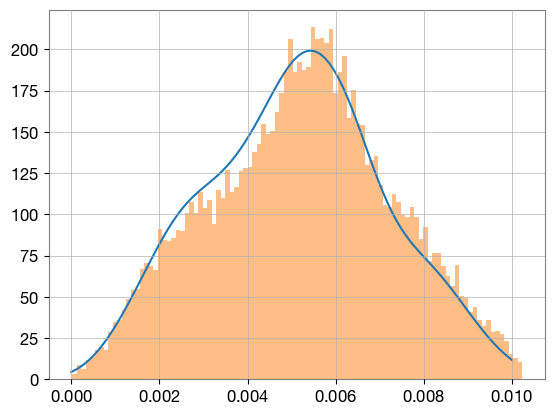

In [12]:
x_max = 0.01
x_values = np.linspace(0.0, x_max, 100)
#test.function(x_values)
plt.plot(x_values, test2.pdf(x_values, x_max*np.ones_like(x_values)), label='function')
# plt.plot(x_values, test2.function(x_values, test2.conditioned_y_array[1]*np.ones_like(x_values)), label='function')
plt.hist(test2.rvs(20000, x_max), bins=100, density=True, alpha=0.5, label='rvs')

# x_max = test2.conditioned_y_array[2]
# x_values = np.linspace(0.0, x_max, 100)
# plt.plot(x_values, test2.function(x_values, x_max*np.ones_like(x_values)), label='function2')

# idx = np.searchsorted(y_array, x_max)
#plt.plot(x_array[idx], z_array[idx], 'o', label='data')
plt.show()

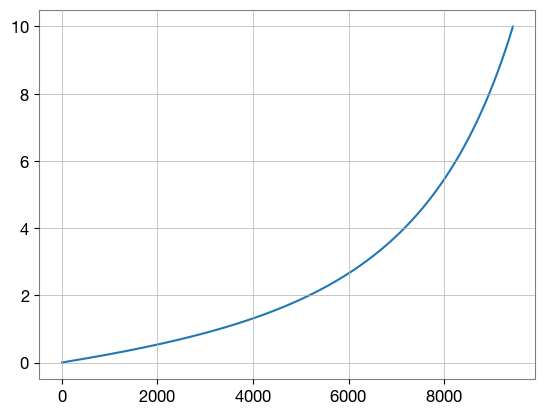

In [44]:
# x_values = np.linspace(0., 10., 100)
#test.function(x_values)
#plt.plot(x_values, test.function(x_values), label='function')
plt.plot(z_array, test.function(z_array), label='inv function')
#plt.plot(x_array[-1], z_array[-1], 'o', label='data')
#plt.plot(z_array[-1], x_array[-1], 'o', label='data')
plt.show()

In [3]:
# numpy 2d norm, with different mu and sigma for each row

In [52]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution

ler = LensGalaxyParameterDistribution()


Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_0.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_0.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_1.pickle
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion/velocity_dispersion_ewoud_0.pickle
Using pre-gererated axis ratio rayleigh pdf coefficients...
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_pickle/axis_ratio/axis_ratio_rayleigh_0.pickle
axis_ratio sampler: CPUDispatcher(<function OpticalDepth.axis_ratio_rayleigh.<locals>.sampler at 0x342589240>) has been set.
Inter

In [66]:
# scipy kde
import numpy as np
import scipy.stats as stats

y_array1 = np.linspace(0.001, 10, 200)
y_array2 = np.geomspace(0.001, 10, 200)
# unique
y_array = np.unique(np.concatenate([y_array1, y_array2]))

x_size = 200
x_list = []
z_list = []
for i, y in enumerate(y_array):
    x_sample = ler.sample_lens_redshift(y*np.ones(x_size))
    # find kde
    kde = stats.gaussian_kde(x_sample)
    x_array = np.linspace(0.0, y, x_size)
    z_array = kde(x_array) 
    z_array /= np.max(z_array)
    x_list.append(x_array)
    z_list.append(z_array)
x_array = np.array(x_list)
z_array = np.array(z_list)
del x_list, z_list

In [55]:
# np save x_array, z_array, y_array
np.save('x_array.npy', x_array)
np.save('z_array.npy', z_array)
np.save('y_array.npy', y_array)

In [20]:
np.geomspace(0.001, 10, 500)

array([1.00000000e-03, 1.01862899e-03, 1.03760502e-03, ...,
       9.63757866e+00, 9.81711702e+00, 1.00000000e+01])

In [33]:
import numpy as np
# test class
class Test:
    def __init__(self, x_array, z_array, y_array, fn=None):
        self.x_array = x_array
        self.z_array = z_array
        self.y_array = y_array

        if callable(fn):
            self.Fn = fn

        if isinstance(fn, type):
            print("fn is a type")
        if callable(fn):
            print("fn is callable")
        if hasattr(fn, '__call__'):
            print("fn has __call__")
        if isinstance(fn, object):
            print("fn is an object")
        if isinstance(fn, object) and hasattr(fn, '__call__'):
            print("fn is an object with __call__")

test = Test(np.load('x_array.npy'), np.load('z_array.npy'), np.load('y_array.npy'), np.random.rand)

fn is callable
fn has __call__
fn is an object
fn is an object with __call__


In [28]:
type(test.Fn)

builtin_function_or_method

In [13]:
# check type of class object
if isinstance(test, Test):
    print(f"test is an instance of {type(test)}")
else:
    print("test is not an instance")

test is an instance of <class '__main__.Test'>


In [35]:
callable(test.Fn)

True

In [42]:
x_array = np.array([1, 2, 3])
len_ = 3
if x_array.ndim == 1:
    x_array = np.array([x_array]*len_)
x_array

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [8]:
# lens_param_samplers = dict(a=1)
lens_param_samplers = None
if (lens_param_samplers is not None) and ('a' in lens_param_samplers):
    print('yes')
else:
    print('no')

no


In [12]:
def test(**kwargs):
    lens_param_samplers = dict(a=1)
    lens_param_samplers.update(kwargs)
    print(lens_param_samplers)
    print(kwargs)

test()

{'a': 1}
{}
